# Assignment 3

Imports

In [1]:
import numpy as np
import scipy as sp
from scipy.optimize import dual_annealing, curve_fit
from scipy.integrate import solve_ivp, odeint
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pandas as pd
from tqdm import tqdm
from numba import jit, njit, prange
import math
import os
import random

In [2]:
SEED = 33
np.random.seed(SEED)

os.makedirs('media', exist_ok=True)

if not os.path.isfile('predator-prey-data.csv'):
    raise FileNotFoundError("File 'predator-prey-data.csv' not found.")

data = pd.read_csv('predator-prey-data.csv').drop(columns=['Unnamed: 0'])
t, x, y = data['t'].to_numpy(), data['x'].to_numpy(), data['y'].to_numpy()

In [3]:
LOW_PARAM_BOUND = 0
UP_PARAM_BOUND = 2
MAX_STEPS_HILLCLIMING = 500
MAX_ITER_SA = 100

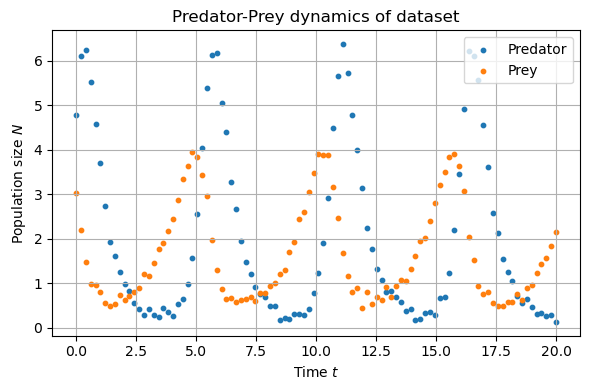

In [4]:
plt.figure(figsize=(6, 4), layout='tight')
plt.scatter(t, x, s=10, label='Predator')
plt.scatter(t, y, s=10, label='Prey')
plt.title('Predator-Prey dynamics of dataset')
plt.xlabel('Time $t$')
plt.ylabel('Population size $N$')
plt.legend(loc='upper right')
plt.grid(True)
plt.savefig('media/dataset.png')
plt.show()

In [5]:
def solve_lv(params, init_conditions, t):
    alpha, beta, gamma, delta = params

    def lv_odes(y, t):
        x, z = y
        dxdt = alpha*x - beta*x*z
        dzdt = delta*x*z - gamma*z
        return np.array([dxdt, dzdt])

    solution = odeint(lv_odes, init_conditions, t)
    return solution

In [6]:
def get_initial_random_guess(lower_bound=LOW_PARAM_BOUND, upper_bound=UP_PARAM_BOUND):
    alpha = random.uniform(lower_bound, upper_bound)
    beta = random.uniform(lower_bound, upper_bound)
    gamma = random.uniform(lower_bound, upper_bound)
    delta = random.uniform(lower_bound, upper_bound)
    return [alpha, beta, gamma, delta]

In [7]:
def get_neighbors(solution, step_size=0.1):
    """Calculate the neighbors of a solution, given a step size."""
    neighbors = []
    for i in range(len(solution)):
        # Add step_size to the parameter if it doesn't exceed PARAM_MAX
        if solution[i] + step_size <= UP_PARAM_BOUND:
            neighbors.append(
                [solution[j] if j != i else solution[i] + step_size for j in range(len(solution))])
        # Subtract step_size from the parameter if it doesn't become less than PARAM_MIN
        if solution[i] - step_size >= LOW_PARAM_BOUND:
            neighbors.append(
                [solution[j] if j != i else solution[i] - step_size for j in range(len(solution))])
    return neighbors


def choose_next_step(loss_function, current_step):
    neighbors = get_neighbors(current_step)
    return min(neighbors, key=loss_function)


def hill_climbing(loss_function, initial_step, max_steps):
    """Perform the Hill Climbing optimization algorithm."""
    current_step = initial_step
    history = [current_step]

    for _ in range(max_steps):
        try:
            next_step = choose_next_step(loss_function, current_step)
            if loss_function(next_step) >= loss_function(current_step):
                break
            history.append(next_step)
            current_step = next_step
        except Exception as e:
            print(f"An error occurred during the hill climbing: {str(e)}")
            break

    return current_step, history

def classic_annealing(*args, **kwargs):
    return dual_annealing(*args, **kwargs, no_local_search=True)

In [8]:
def mse_objective(params):
    initial_conditions = [y[0], x[0]]
    sim_data = solve_lv(params, initial_conditions, t)
    mse = mean_squared_error(data[['y', 'x']].values, sim_data)
    return mse

def mae_objective(params):
    initial_conditions = [y[0], x[0]]
    sim_data = solve_lv(params, initial_conditions, t)
    mae = mean_absolute_error(data[['y', 'x']].values, np.abs(sim_data))
    return mae

In [9]:
bounds = [(LOW_PARAM_BOUND, UP_PARAM_BOUND)] * 4
initial_guess = get_initial_random_guess()
hc_optimizers = [hill_climbing]
sa_optimizers = [classic_annealing, dual_annealing]
optimizers = hc_optimizers + sa_optimizers
objectives = [mse_objective, mae_objective]
est_params = {opt.__name__: {obj.__name__: [] for obj in objectives} for opt in optimizers}


for obj in objectives:
    for opt in hc_optimizers:
        params, _ = hill_climbing(
            obj, initial_guess, max_steps=MAX_STEPS_HILLCLIMING)
        est_params[opt.__name__][obj.__name__] = params
        print(f"Params of {opt.__name__} with {obj.__name__}: {[f'{p:.3f}' for p in params]} - Loss: {obj(params):.2e}")
    for opt in sa_optimizers:
        params = opt(obj, bounds=bounds, maxiter=MAX_ITER_SA).x
        est_params[opt.__name__][obj.__name__] = params
        print(f"Params of {opt.__name__} with {obj.__name__}: {[f'{p:.3f}' for p in params]} - Loss: {obj(params):.2e}")

Params of hill_climbing with mse_objective: ['0.683', '1.026', '0.767', '0.718'] - Loss: 3.81e+00
Params of classic_annealing with mse_objective: ['1.359', '0.713', '1.511', '1.290'] - Loss: 2.64e-01


C:\conda\lib\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\conda\lib\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


Params of dual_annealing with mse_objective: ['0.860', '0.440', '2.000', '1.158'] - Loss: 9.63e-03
Params of hill_climbing with mae_objective: ['0.683', '1.126', '0.767', '0.518'] - Loss: 1.56e+00
Params of classic_annealing with mae_objective: ['1.379', '0.586', '1.183', '0.682'] - Loss: 3.44e-01


C:\conda\lib\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\conda\lib\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\conda\lib\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\conda\lib\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


Params of dual_annealing with mae_objective: ['0.876', '0.449', '1.965', '1.142'] - Loss: 7.79e-02


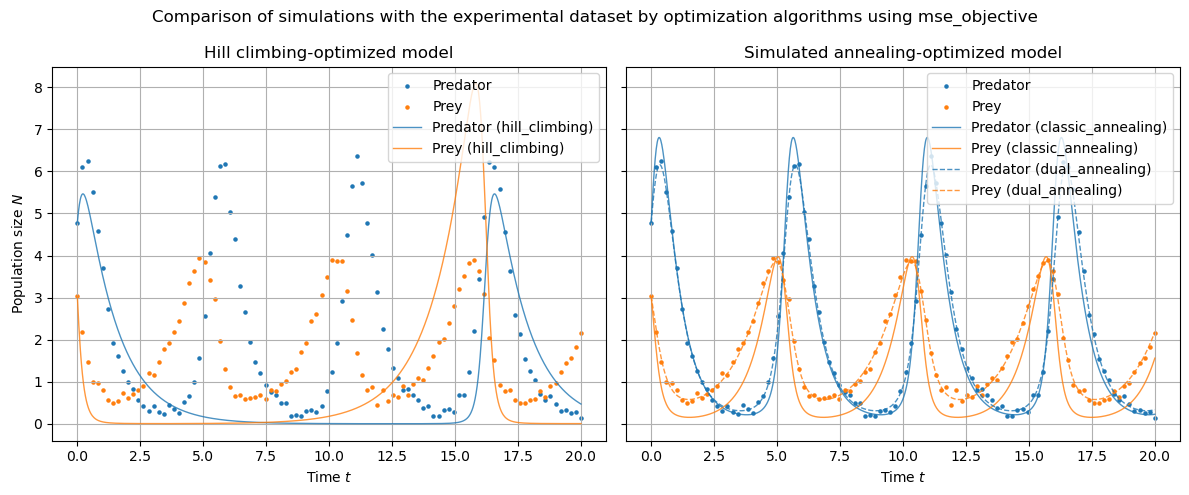

In [10]:
def plot_comparison_optimizers(hc_optimizers, sa_optimizers, objective=mse_objective, linestyles=['-', '--', ':'], colors=['tab:blue', 'tab:orange']):
    t_detail = np.linspace(0, 20, 1000)
    fig, axs = plt.subplots(1, 2, figsize=(12, 5), layout='tight', sharey=True)
    fig.suptitle(f'Comparison of simulations with the experimental dataset by optimization algorithms using {objective.__name__}')
    axs[0].scatter(t, x, s=5, label='Predator', color=colors[0])
    axs[0].scatter(t, y, s=5, label='Prey', color=colors[1])
    for i, opt in enumerate(hc_optimizers):
        params = est_params[opt.__name__][objective.__name__]
        initial_conditions = [y[0], x[0]]
        sim_data = solve_lv(params, initial_conditions, t_detail)
        axs[0].plot(t_detail, sim_data[:, 1], label=f'Predator ({opt.__name__})', linestyle=linestyles[i], color=colors[0], linewidth=1, alpha=0.8)
        axs[0].plot(t_detail, sim_data[:, 0], label=f'Prey ({opt.__name__})', linestyle=linestyles[i], color=colors[1], linewidth=1, alpha=0.8)
    axs[0].set_title('Hill climbing-optimized model')
    axs[0].set_xlabel('Time $t$')
    axs[0].set_ylabel('Population size $N$')
    axs[0].legend(loc='upper right')
    axs[0].grid(True)
    axs[1].scatter(t, x, s=5, label='Predator', color=colors[0])
    axs[1].scatter(t, y, s=5, label='Prey', color=colors[1])
    for i, opt in enumerate(sa_optimizers):
        params = est_params[opt.__name__][objective.__name__]
        initial_conditions = [y[0], x[0]]
        sim_data = solve_lv(params, initial_conditions, t_detail)
        axs[1].plot(t_detail, sim_data[:, 1], label=f'Predator ({opt.__name__})', linestyle=linestyles[i], color=colors[0], linewidth=1, alpha=0.8)
        axs[1].plot(t_detail, sim_data[:, 0], label=f'Prey ({opt.__name__})', linestyle=linestyles[i], color=colors[1], linewidth=1, alpha=0.8)
    axs[1].set_title('Simulated annealing-optimized model')
    axs[1].set_xlabel('Time $t$')
    axs[1].legend(loc='upper right')
    axs[1].grid(True)
    plt.savefig('media/comparison_optimizers.png')
    plt.show()

plot_comparison_optimizers(hc_optimizers, sa_optimizers)

Removing samples functionality

  0%|▍                                                                                 | 1/200 [00:01<04:59,  1.51s/it]

params: [1.52896196 0.78131841 1.25314822 0.93832918]
Minimum and Maximum of sim_data: 0.1839884548884614, 4.968753733845056
MSE: 1.044568087164141


  1%|▊                                                                                 | 2/200 [00:03<05:08,  1.56s/it]

params: [1.6781722  0.74935209 1.29059731 1.38240414]
Minimum and Maximum of sim_data: 0.08395607076441211, 7.148716636939741
MSE: 3.7271369852387273


  2%|█▏                                                                                | 3/200 [00:04<05:08,  1.56s/it]

params: [1.39097102 0.87323402 1.6695456  1.57310583]
Minimum and Maximum of sim_data: 0.09062586849376089, 4.78163509155479
MSE: 6.416601120477303


  2%|█▋                                                                                | 4/200 [00:06<05:01,  1.54s/it]

params: [1.25202838 0.53490431 1.29117065 0.75041856]
Minimum and Maximum of sim_data: 0.5346955767182622, 5.489015612968253
MSE: 5.229506702795629


  2%|██                                                                                | 5/200 [00:07<04:57,  1.52s/it]

params: [0.94646042 0.60646097 1.88208536 0.99111861]
Minimum and Maximum of sim_data: 0.20681653527925808, 5.361813784446576
MSE: 4.120939364106375


  3%|██▍                                                                               | 6/200 [00:09<04:55,  1.52s/it]

params: [1.1371401  0.62625959 1.56498494 0.92377279]
Minimum and Maximum of sim_data: 0.30494414173955775, 4.78163509155479
MSE: 6.789374034560693


  4%|██▊                                                                               | 7/200 [00:10<04:52,  1.52s/it]

params: [0.83084308 0.40021513 1.9674627  1.05598037]
Minimum and Maximum of sim_data: 0.42921820284801454, 5.671462907621264
MSE: 1.6766080871266529


  4%|███▎                                                                              | 8/200 [00:12<04:49,  1.51s/it]

params: [1.26029745 0.78369499 1.48835422 0.87359194]
Minimum and Maximum of sim_data: 0.2861454527168152, 5.19719236150339
MSE: 5.588453537968627


  4%|███▋                                                                              | 9/200 [00:13<04:55,  1.55s/it]

params: [1.83286931 1.4467351  1.53087232 1.5200254 ]
Minimum and Maximum of sim_data: 0.030790580952151682, 4.78163509155479
MSE: 1.9633902383893478


  5%|████                                                                             | 10/200 [00:15<04:54,  1.55s/it]

params: [1.90246697 1.07539493 1.20994773 1.20901014]
Minimum and Maximum of sim_data: 0.051744373974457816, 4.78163509155479
MSE: 0.46218690489441966


  6%|████▍                                                                            | 11/200 [00:16<04:53,  1.55s/it]

params: [1.27592649 0.60769612 1.59849182 1.44772208]
Minimum and Maximum of sim_data: 0.15569741562392816, 6.770215019103329
MSE: 8.029649940095346


  6%|████▊                                                                            | 12/200 [00:18<04:47,  1.53s/it]

params: [1.5811698  0.72296625 1.13764509 0.81314313]
Minimum and Maximum of sim_data: 0.23472570100215367, 5.789036481896702
MSE: 9.815117830939098


  6%|█████▎                                                                           | 13/200 [00:19<04:44,  1.52s/it]

params: [1.2893613  0.65182675 1.42192879 1.00327751]
Minimum and Maximum of sim_data: 0.26922006881606714, 5.877961125693827
MSE: 0.07033718993965248


  7%|█████▋                                                                           | 14/200 [00:21<04:43,  1.53s/it]

params: [1.56672864 0.82527936 1.16477473 0.74166288]
Minimum and Maximum of sim_data: 0.22869678617646677, 5.198668358449434
MSE: 4.907518255743767


  8%|██████                                                                           | 15/200 [00:22<04:39,  1.51s/it]

params: [1.00603941 0.4893897  1.74871156 1.12709859]
Minimum and Maximum of sim_data: 0.36112203261669595, 4.78163509155479
MSE: 5.573619577982498


  8%|██████▍                                                                          | 16/200 [00:24<04:34,  1.49s/it]

params: [1.61873187 1.01528707 1.37533386 1.19232178]
Minimum and Maximum of sim_data: 0.08255229925794123, 4.78163509155479
MSE: 9.689222914632271


  8%|██████▉                                                                          | 17/200 [00:25<04:29,  1.47s/it]

params: [1.17736772 0.52809253 1.35552647 0.73967398]
Minimum and Maximum of sim_data: 0.5922434577909903, 5.216114931778616
MSE: 3.2685850297843606


  9%|███████▎                                                                         | 18/200 [00:27<04:51,  1.60s/it]

params: [1.91990302 0.94063689 1.11183973 1.12837632]
Minimum and Maximum of sim_data: 0.06542530711855718, 6.549859152853321
MSE: 6.768127794377436


 10%|███████▋                                                                         | 19/200 [00:29<04:47,  1.59s/it]

params: [1.8329334  1.07555542 1.08365076 0.69358779]
Minimum and Maximum of sim_data: 0.127976201897886, 5.888368067273163
MSE: 0.6075214341803264


 10%|████████                                                                         | 20/200 [00:30<04:46,  1.59s/it]

params: [1.25806814 0.81968714 1.48443153 0.7722389 ]
Minimum and Maximum of sim_data: 0.2474034333120666, 5.429665895826663
MSE: 8.787967001626853


 10%|████████▌                                                                        | 21/200 [00:32<04:38,  1.55s/it]

params: [1.47788326 0.65902416 1.16076546 0.75899926]
Minimum and Maximum of sim_data: 0.3230450369546702, 5.671272055772412
MSE: 7.02074931957852


 11%|████████▉                                                                        | 22/200 [00:33<04:31,  1.52s/it]

params: [1.8839591  0.9531992  1.02988722 0.7310216 ]
Minimum and Maximum of sim_data: 0.1468341685350877, 5.138792195158479
MSE: 0.2423299049757432


 12%|█████████▎                                                                       | 23/200 [00:35<04:31,  1.53s/it]

params: [1.26416543 0.64269969 1.50233737 1.16668994]
Minimum and Maximum of sim_data: 0.2179665579057367, 6.5180559408078285
MSE: 5.632893293543223


 12%|█████████▋                                                                       | 24/200 [00:36<04:27,  1.52s/it]

params: [1.17585784 0.6863369  1.51840749 0.85884675]
Minimum and Maximum of sim_data: 0.2763370179778462, 5.368741227224373
MSE: 0.16014232048782756


 12%|██████████▏                                                                      | 25/200 [00:38<04:26,  1.52s/it]

params: [1.57845702 0.71410906 1.13755965 0.81717977]
Minimum and Maximum of sim_data: 0.23619366714462112, 5.804499453588678
MSE: 0.4144145408368989


 13%|██████████▌                                                                      | 26/200 [00:39<04:23,  1.52s/it]

params: [1.60167665 1.0087172  1.4797083  1.4287327 ]
Minimum and Maximum of sim_data: 0.06455593682665363, 4.961340247635393
MSE: 6.264250118092994


 14%|██████████▉                                                                      | 27/200 [00:41<04:27,  1.54s/it]

params: [1.95002076 0.94792327 1.02787642 0.7878996 ]
Minimum and Maximum of sim_data: 0.131625757174159, 5.508491714231722
MSE: 0.5678838782843045


 14%|███████████▎                                                                     | 28/200 [00:43<04:25,  1.54s/it]

params: [1.90503868 0.89091577 0.99032063 0.78147905]
Minimum and Maximum of sim_data: 0.13618880069211872, 5.66857904570823
MSE: 0.7285917913784365


 14%|███████████▋                                                                     | 29/200 [00:44<04:24,  1.55s/it]

params: [1.4791126  0.92159196 1.51285095 1.34002608]
Minimum and Maximum of sim_data: 0.09808542073183799, 6.144505836525853
MSE: 4.098508188171832


 15%|████████████▏                                                                    | 30/200 [00:46<04:18,  1.52s/it]

params: [1.82697593 0.78500507 0.98709134 0.7519181 ]
Minimum and Maximum of sim_data: 0.19264837219576578, 5.122931457440536
MSE: 0.2588512318177322


 16%|████████████▌                                                                    | 31/200 [00:47<04:22,  1.55s/it]

params: [1.96562946 1.39556435 1.39977071 1.51340258]
Minimum and Maximum of sim_data: 0.02253111792848733, 5.472718761626392
MSE: 0.7015121900362762


 16%|████████████▉                                                                    | 32/200 [00:49<04:20,  1.55s/it]

params: [1.1162376  0.51314592 1.59738931 1.17304765]
Minimum and Maximum of sim_data: 0.3093142941802718, 6.912006270694462
MSE: 4.8163301153396025


 16%|█████████████▎                                                                   | 33/200 [00:50<04:21,  1.56s/it]

params: [0.91948211 0.5770139  1.87201284 0.91345366]
Minimum and Maximum of sim_data: 0.230039957238908, 5.201766175204567
MSE: 0.7812978135382478


 17%|█████████████▊                                                                   | 34/200 [00:52<04:14,  1.54s/it]

params: [0.9441019  0.48959105 1.69230967 0.81058713]
Minimum and Maximum of sim_data: 0.4352367954106647, 5.229538252559758
MSE: 0.5348678255007795


 18%|██████████████▏                                                                  | 35/200 [00:53<04:16,  1.55s/it]

params: [1.56831076 1.25083282 1.79870271 1.86897546]
Minimum and Maximum of sim_data: 0.03445889261192255, 6.6348509237684405
MSE: 1.1454760456611885


 18%|██████████████▌                                                                  | 36/200 [00:55<04:12,  1.54s/it]

params: [1.05864225 0.58427474 1.8544902  1.36058574]
Minimum and Maximum of sim_data: 0.17876079809065576, 6.613078416906711
MSE: 0.36471324225224555


 18%|██████████████▉                                                                  | 37/200 [00:56<04:10,  1.54s/it]

params: [1.35159837 0.89593902 1.53635223 1.09188069]
Minimum and Maximum of sim_data: 0.14454933594594768, 5.6400794867676165
MSE: 9.788627556727688


 19%|███████████████▍                                                                 | 38/200 [00:58<04:08,  1.53s/it]

params: [1.29666275 0.83287294 1.54100504 1.04458877]
Minimum and Maximum of sim_data: 0.16580088404774082, 5.393641048364616
MSE: 1.545064865527431


 20%|███████████████▊                                                                 | 39/200 [00:59<04:00,  1.49s/it]

params: [1.57008089 0.75551582 1.15001411 0.80308739]
Minimum and Maximum of sim_data: 0.22529145588682595, 5.2028936017614695
MSE: 1.8215233109908462


 20%|████████████████▏                                                                | 40/200 [01:01<03:56,  1.48s/it]

params: [1.07206174 0.46003326 1.56257874 0.98363072]
Minimum and Maximum of sim_data: 0.48928437655197704, 5.701535061526118
MSE: 0.12626594967287844


 20%|████████████████▌                                                                | 41/200 [01:02<03:57,  1.49s/it]

params: [1.55207984 0.74004519 1.2297619  0.98601179]
Minimum and Maximum of sim_data: 0.17191780119079142, 6.23833372946546
MSE: 0.4246442160475


 21%|█████████████████                                                                | 42/200 [01:04<03:51,  1.46s/it]

params: [1.17982512 0.60458257 1.39855899 0.7328087 ]
Minimum and Maximum of sim_data: 0.451279295404545, 5.24717904685714
MSE: 1.063401377468122


 22%|█████████████████▍                                                               | 43/200 [01:05<03:54,  1.49s/it]

params: [1.87587389 1.1115016  1.23439207 1.17651524]
Minimum and Maximum of sim_data: 0.05313303831911316, 5.715302508914092
MSE: 7.264478062404177


 22%|█████████████████▊                                                               | 44/200 [01:07<03:51,  1.49s/it]

params: [1.03007974 0.49050685 1.67902652 1.08283155]
Minimum and Maximum of sim_data: 0.36662331542741017, 6.33918228166465
MSE: 0.05838173616217083


 22%|██████████████████▏                                                              | 45/200 [01:08<03:46,  1.46s/it]

params: [1.05310775 0.48650402 1.57285689 0.88475144]
Minimum and Maximum of sim_data: 0.5186828256567491, 5.593470846023606
MSE: 4.0489402397536605


 23%|██████████████████▋                                                              | 46/200 [01:09<03:41,  1.44s/it]

params: [1.87826328 0.82607486 0.99814318 0.83247831]
Minimum and Maximum of sim_data: 0.1419122660355741, 6.000955738369196
MSE: 0.33769255642220647


 24%|███████████████████                                                              | 47/200 [01:11<03:44,  1.47s/it]

params: [1.28982152 0.99147286 1.92024522 1.66057795]
Minimum and Maximum of sim_data: 0.047066647008534045, 6.00890199804203
MSE: 0.5980574642255221


 24%|███████████████████▍                                                             | 48/200 [01:13<03:43,  1.47s/it]

params: [1.13875395 0.64100959 1.7719076  1.38161814]
Minimum and Maximum of sim_data: 0.16172220751247499, 6.468741643419783
MSE: 3.5487467133415844


 24%|███████████████████▊                                                             | 49/200 [01:14<03:44,  1.49s/it]

params: [1.44256216 0.90300526 1.56296925 1.4047841 ]
Minimum and Maximum of sim_data: 0.09460171922345814, 6.5311542944876315
MSE: 0.3624287863844491


 25%|████████████████████▎                                                            | 50/200 [01:16<03:47,  1.51s/it]

params: [1.1928154  0.82170122 1.79749778 1.33291252]
Minimum and Maximum of sim_data: 0.09808601658154549, 6.077424938742729
MSE: 0.4993079763811141


 26%|████████████████████▋                                                            | 51/200 [01:17<03:43,  1.50s/it]

params: [1.37961746 0.82970441 1.38973321 0.86788886]
Minimum and Maximum of sim_data: 0.23405714068642527, 5.3811474205088565
MSE: 0.7546304856811632


 26%|█████████████████████                                                            | 52/200 [01:19<03:42,  1.50s/it]

params: [1.26328212 0.87692917 1.75572125 1.37610344]
Minimum and Maximum of sim_data: 0.09228121931202639, 6.155895385200059
MSE: 5.114511737916625


 26%|█████████████████████▍                                                           | 53/200 [01:20<03:37,  1.48s/it]

params: [1.99228631 0.83150849 0.85554817 0.5486725 ]
Minimum and Maximum of sim_data: 0.2520250283369023, 5.325921518314401
MSE: 3.8049481389421533


 27%|█████████████████████▊                                                           | 54/200 [01:22<03:39,  1.51s/it]

params: [1.95434359 1.16916551 1.0991903  0.81527378]
Minimum and Maximum of sim_data: 0.08183524088594628, 5.616567384944935
MSE: 1.053682688176784


 28%|██████████████████████▎                                                          | 55/200 [01:23<03:36,  1.50s/it]

params: [1.19675555 0.68259053 1.51610776 0.92808584]
Minimum and Maximum of sim_data: 0.2696265210990852, 5.551196025907437
MSE: 0.12343626518975985


 28%|██████████████████████▋                                                          | 56/200 [01:25<03:38,  1.52s/it]

params: [1.46457997 1.15925336 1.84305934 1.78019444]
Minimum and Maximum of sim_data: 0.03835127231475944, 6.537321606810588
MSE: 0.8299405519404337


 28%|███████████████████████                                                          | 57/200 [01:26<03:37,  1.52s/it]

params: [1.15135895 0.57517311 1.69489367 1.32048021]
Minimum and Maximum of sim_data: 0.23894484296648769, 6.831238743591351
MSE: 0.32553316712163305


 29%|███████████████████████▍                                                         | 58/200 [01:28<03:33,  1.51s/it]

params: [1.63770504 0.84441161 1.09572513 0.65689186]
Minimum and Maximum of sim_data: 0.24730711305956754, 5.245295747364648
MSE: 0.24870101876477885


 30%|███████████████████████▉                                                         | 59/200 [01:29<03:37,  1.54s/it]

params: [1.9308051  1.17334292 1.42853665 1.84773736]
Minimum and Maximum of sim_data: 0.020165020663099012, 7.298889326798713
MSE: 3.229010647325912


 30%|████████████████████████▎                                                        | 60/200 [01:31<03:36,  1.54s/it]

params: [1.07006513 0.68062889 1.80766997 1.19079516]
Minimum and Maximum of sim_data: 0.14978180969184401, 5.359776030023316
MSE: 0.6586471689929041


 30%|████████████████████████▋                                                        | 61/200 [01:32<03:31,  1.52s/it]

params: [0.80152042 0.3572686  1.97532421 1.03004932]
Minimum and Maximum of sim_data: 0.5306446471262137, 5.956568861607355
MSE: 1.9378606635340314


 31%|█████████████████████████                                                        | 62/200 [01:34<03:29,  1.52s/it]

params: [1.671435   0.67683461 1.131167   1.0135376 ]
Minimum and Maximum of sim_data: 0.15270016873461068, 6.882855831375053
MSE: 8.839378422930027


 32%|█████████████████████████▌                                                       | 63/200 [01:35<03:25,  1.50s/it]

params: [1.01265966 0.50441839 1.59376198 0.80448785]
Minimum and Maximum of sim_data: 0.4739035746035012, 5.3294837136530155
MSE: 0.0859702929884269


 32%|█████████████████████████▉                                                       | 64/200 [01:37<03:24,  1.50s/it]

params: [1.76700899 0.95457315 1.14190928 0.89580595]
Minimum and Maximum of sim_data: 0.11512345610875184, 5.510264665659031
MSE: 0.5240820417513343


 32%|██████████████████████████▎                                                      | 65/200 [01:38<03:18,  1.47s/it]

params: [0.85896957 0.41675356 1.93772576 1.06862297]
Minimum and Maximum of sim_data: 0.398568123932358, 5.956204302368928
MSE: 0.8308357822743092


 33%|██████████████████████████▋                                                      | 66/200 [01:40<03:22,  1.51s/it]

params: [1.45627959 0.60140597 1.32823349 1.19574667]
Minimum and Maximum of sim_data: 0.1663607674782031, 7.3031925581941595
MSE: 2.2615486755887844


 34%|███████████████████████████▏                                                     | 67/200 [01:41<03:22,  1.52s/it]

params: [1.82499158 0.9022944  1.23683855 1.36030184]
Minimum and Maximum of sim_data: 0.05697475036231431, 7.14447317338841
MSE: 2.989229268439427


 34%|███████████████████████████▌                                                     | 68/200 [01:43<03:21,  1.53s/it]

params: [1.72488423 1.15756181 1.4383873  1.40660425]
Minimum and Maximum of sim_data: 0.046910969984189185, 6.275129139579534
MSE: 2.5588178427567008


 34%|███████████████████████████▉                                                     | 69/200 [01:44<03:17,  1.51s/it]

params: [1.70131248 0.67275828 0.93851689 0.52927092]
Minimum and Maximum of sim_data: 0.4462223480250055, 5.2682038223146375
MSE: 0.3500380686832268


 35%|████████████████████████████▎                                                    | 70/200 [01:46<03:19,  1.54s/it]

params: [1.34869481 0.67477393 1.50831148 1.30313128]
Minimum and Maximum of sim_data: 0.1588623381872834, 7.020359093328877
MSE: 1.2146805283535478


 36%|████████████████████████████▊                                                    | 71/200 [01:47<03:13,  1.50s/it]

params: [0.98201788 0.46536623 1.609115   0.81012517]
Minimum and Maximum of sim_data: 0.5402776673468286, 5.372138774276344
MSE: 0.336561488574548


 36%|█████████████████████████████▏                                                   | 72/200 [01:49<03:08,  1.47s/it]

params: [1.0016701  0.43214242 1.54017979 0.80999365]
Minimum and Maximum of sim_data: 0.6665322311754054, 5.535060108781104
MSE: 0.18772116430245198


 36%|█████████████████████████████▌                                                   | 73/200 [01:50<03:05,  1.46s/it]

params: [0.96524391 0.45302518 1.80973544 1.12019907]
Minimum and Maximum of sim_data: 0.3819154470765738, 6.3720871564992505
MSE: 3.8673922348303904


 37%|█████████████████████████████▉                                                   | 74/200 [01:52<03:07,  1.49s/it]

params: [1.45068526 1.13352417 1.68304901 1.36335799]
Minimum and Maximum of sim_data: 0.06263950681501627, 5.779835003032424
MSE: 3.4410388190329133


 38%|██████████████████████████████▍                                                  | 75/200 [01:53<03:08,  1.51s/it]

params: [1.67665614 1.11112761 1.54424942 1.65263452]
Minimum and Maximum of sim_data: 0.04139613771825476, 6.782207351576532
MSE: 0.7952132258277903


 38%|██████████████████████████████▊                                                  | 76/200 [01:55<03:08,  1.52s/it]

params: [1.27576977 0.74630189 1.49403709 0.98504261]
Minimum and Maximum of sim_data: 0.23328130466275754, 5.562701824264893
MSE: 2.780811294787265


 38%|███████████████████████████████▏                                                 | 77/200 [01:56<03:09,  1.54s/it]

params: [1.38856717 0.86497627 1.72922498 1.73685927]
Minimum and Maximum of sim_data: 0.07632925343175388, 7.330338679775182
MSE: 0.5619963424547121


 39%|███████████████████████████████▌                                                 | 78/200 [01:58<03:05,  1.52s/it]

params: [1.14224967 0.4778114  1.4857334  1.0002302 ]
Minimum and Maximum of sim_data: 0.4096794610833722, 6.55311174787974
MSE: 0.20519733411342223


 40%|███████████████████████████████▉                                                 | 79/200 [01:59<03:04,  1.52s/it]

params: [1.87682944 1.01913793 1.05129581 0.70089178]
Minimum and Maximum of sim_data: 0.14036653823849077, 5.479802576834746
MSE: 4.148536792900834


 40%|████████████████████████████████▍                                                | 80/200 [02:01<03:00,  1.51s/it]

params: [1.22493051 0.64822432 1.46826428 0.93462536]
Minimum and Maximum of sim_data: 0.3285052327061541, 5.255883820275105
MSE: 0.8838905423052843


 40%|████████████████████████████████▊                                                | 81/200 [02:02<02:54,  1.47s/it]

params: [1.50037308 0.76010063 1.36236741 1.16676772]
Minimum and Maximum of sim_data: 0.14078675268963514, 6.450249981958155
MSE: 0.3133676614832421


 41%|█████████████████████████████████▏                                               | 82/200 [02:04<02:55,  1.49s/it]

params: [1.37558638 0.56489672 1.33884582 1.13312883]
Minimum and Maximum of sim_data: 0.2064303632409895, 7.286106718071115
MSE: 0.435379719871328


 42%|█████████████████████████████████▌                                               | 83/200 [02:05<02:54,  1.49s/it]

params: [1.78249703 0.98587362 1.08741491 0.72598175]
Minimum and Maximum of sim_data: 0.14664370588946984, 5.574674180224399
MSE: 0.558097511452262


 42%|██████████████████████████████████                                               | 84/200 [02:07<02:53,  1.50s/it]

params: [1.03987163 0.59846938 1.86269574 1.31692287]
Minimum and Maximum of sim_data: 0.16982342118166685, 6.490575937485135
MSE: 0.4346097234313736


 42%|██████████████████████████████████▍                                              | 85/200 [02:08<02:52,  1.50s/it]

params: [1.30346978 0.79688725 1.5965964  1.25549948]
Minimum and Maximum of sim_data: 0.15166597515207347, 6.254075154518267
MSE: 0.24779604137557837


 43%|██████████████████████████████████▊                                              | 86/200 [02:10<02:50,  1.49s/it]

params: [1.41719552 0.78100918 1.38385303 1.03768895]
Minimum and Maximum of sim_data: 0.18042257540422052, 5.9956373760387
MSE: 0.38760462317362565


 44%|███████████████████████████████████▏                                             | 87/200 [02:11<02:51,  1.52s/it]

params: [1.119667   0.81016845 1.96538746 1.49506635]
Minimum and Maximum of sim_data: 0.06934623110537348, 6.299304668258354
MSE: 0.9263139258806985


 44%|███████████████████████████████████▋                                             | 88/200 [02:13<02:49,  1.51s/it]

params: [1.54313005 0.88592934 1.48708333 1.49334631]
Minimum and Maximum of sim_data: 0.07220218931169664, 7.01119003489396
MSE: 0.4279900104841971


 44%|████████████████████████████████████                                             | 89/200 [02:14<02:50,  1.54s/it]

params: [1.87033349 0.90824066 1.3577486  1.80342431]
Minimum and Maximum of sim_data: 0.028916535034365174, 8.361305465305028
MSE: 1.1646047761103708


 45%|████████████████████████████████████▍                                            | 90/200 [02:16<02:49,  1.54s/it]

params: [1.72004956 0.97700323 1.33257443 1.33855855]
Minimum and Maximum of sim_data: 0.06064219891259784, 6.325449391318643
MSE: 1.5390418079066481


 46%|████████████████████████████████████▊                                            | 91/200 [02:17<02:45,  1.52s/it]

params: [1.34052521 0.80343395 1.40562657 0.86893228]
Minimum and Maximum of sim_data: 0.24390589633204116, 5.4147978076016585
MSE: 0.21350596504293645


 46%|█████████████████████████████████████▎                                           | 92/200 [02:19<02:42,  1.50s/it]

params: [1.24020133 0.80046719 1.57027429 0.95208214]
Minimum and Maximum of sim_data: 0.18371179531042858, 5.430388527579367
MSE: 0.25164701288627817


 46%|█████████████████████████████████████▋                                           | 93/200 [02:20<02:41,  1.51s/it]

params: [0.90635154 0.35540247 1.66891091 0.78830656]
Minimum and Maximum of sim_data: 0.9181248312447797, 5.4686658295658646
MSE: 0.8525086946998626


 47%|██████████████████████████████████████                                           | 94/200 [02:22<02:38,  1.49s/it]

params: [1.26803356 0.60889125 1.40349501 0.95381126]
Minimum and Maximum of sim_data: 0.3139170008393274, 6.014649117917931
MSE: 0.07709011237136773


 48%|██████████████████████████████████████▍                                          | 95/200 [02:23<02:35,  1.48s/it]

params: [0.99180051 0.413597   1.47738439 0.66989994]
Minimum and Maximum of sim_data: 0.8558867234646186, 5.138749604468206
MSE: 0.6534537281982369


 48%|██████████████████████████████████████▉                                          | 96/200 [02:25<02:31,  1.46s/it]

params: [0.99241149 0.46958846 1.6147402  0.82640943]
Minimum and Maximum of sim_data: 0.5329185098601332, 5.440219662594816
MSE: 0.09527119616689775


 48%|███████████████████████████████████████▎                                         | 97/200 [02:26<02:31,  1.47s/it]

params: [1.29529584 0.81368824 1.6761281  1.39068   ]
Minimum and Maximum of sim_data: 0.11833428820892643, 6.490139399321826
MSE: 0.3057249901228892


 49%|███████████████████████████████████████▋                                         | 98/200 [02:28<02:28,  1.45s/it]

params: [0.81475198 0.4100716  1.99469864 1.03716133]
Minimum and Maximum of sim_data: 0.3888906735167463, 5.683613910712318
MSE: 1.5227268320527498


 50%|████████████████████████████████████████                                         | 99/200 [02:29<02:27,  1.46s/it]

params: [1.66298257 0.78040254 1.07262371 0.71627494]
Minimum and Maximum of sim_data: 0.24324570438636373, 5.532883812061954
MSE: 0.3786417908824009


 50%|████████████████████████████████████████                                        | 100/200 [02:31<02:28,  1.49s/it]

params: [1.47609126 0.82348392 1.44442095 1.34586361]
Minimum and Maximum of sim_data: 0.09821610007551305, 6.773896151912313
MSE: 0.927781605634978


 50%|████████████████████████████████████████▍                                       | 101/200 [02:32<02:27,  1.49s/it]

params: [1.46379087 0.88426446 1.2687721  0.66733789]
Minimum and Maximum of sim_data: 0.2732169306831817, 6.209590862203585
MSE: 0.49018160281739986


 51%|████████████████████████████████████████▊                                       | 102/200 [02:34<02:27,  1.50s/it]

params: [1.99398193 1.06237794 1.02886495 0.79525999]
Minimum and Maximum of sim_data: 0.0954743969668573, 5.520901115332276
MSE: 0.565928851013231


 52%|█████████████████████████████████████████▏                                      | 103/200 [02:35<02:23,  1.48s/it]

params: [1.1468849  0.48906163 1.50286773 1.02262939]
Minimum and Maximum of sim_data: 0.3914634368470655, 6.572183642143228
MSE: 0.15771048273778174


 52%|█████████████████████████████████████████▌                                      | 104/200 [02:37<02:20,  1.46s/it]

params: [1.86779568 0.77627316 0.9120294  0.57695594]
Minimum and Maximum of sim_data: 0.28867976062390244, 5.379779117299302
MSE: 0.29170358058199475


 52%|██████████████████████████████████████████                                      | 105/200 [02:38<02:21,  1.49s/it]

params: [1.87415083 1.00459701 1.03927103 0.65120129]
Minimum and Maximum of sim_data: 0.16357142028431657, 5.854491626829438
MSE: 0.4666479637664706


 53%|██████████████████████████████████████████▍                                     | 106/200 [02:40<02:24,  1.54s/it]

params: [1.35088326 0.82560853 1.63637765 1.44394586]
Minimum and Maximum of sim_data: 0.11441675592017882, 6.706078543017771
MSE: 1.4539791641321607


 54%|██████████████████████████████████████████▊                                     | 107/200 [02:41<02:23,  1.55s/it]

params: [1.2570674  0.58161603 1.52212765 1.21800002]
Minimum and Maximum of sim_data: 0.22722435084862214, 7.0206968111262515
MSE: 0.23369072545051456


 54%|███████████████████████████████████████████▏                                    | 108/200 [02:43<02:23,  1.56s/it]

params: [1.29505685 0.72151485 1.42522355 0.92576316]
Minimum and Maximum of sim_data: 0.2707694650695789, 5.663729352084437
MSE: 1.7303660711809155


 55%|███████████████████████████████████████████▌                                    | 109/200 [02:45<02:24,  1.59s/it]

params: [1.7658218  0.87406453 1.04870129 0.70314751]
Minimum and Maximum of sim_data: 0.19275847691029094, 5.413793328002703
MSE: 0.21589596318836446


 55%|████████████████████████████████████████████                                    | 110/200 [02:46<02:21,  1.57s/it]

params: [1.34427214 0.86598934 1.43402673 0.86762802]
Minimum and Maximum of sim_data: 0.19660826411944618, 5.4392254469758266
MSE: 2.629050873857341


 56%|████████████████████████████████████████████▍                                   | 111/200 [02:48<02:19,  1.57s/it]

params: [0.98409094 0.49639607 1.74310221 1.03507033]
Minimum and Maximum of sim_data: 0.3506146469548929, 5.967575424638072
MSE: 0.01985898693440253


 56%|████████████████████████████████████████████▊                                   | 112/200 [02:49<02:17,  1.57s/it]

params: [1.00236573 0.45657771 1.57842508 0.83658908]
Minimum and Maximum of sim_data: 0.5689561177540108, 5.578804556908085
MSE: 0.11271267722049585


 56%|█████████████████████████████████████████████▏                                  | 113/200 [02:51<02:18,  1.59s/it]

params: [1.3610792  0.828706   1.65927938 1.5196988 ]
Minimum and Maximum of sim_data: 0.10377040540450091, 6.88742915923047
MSE: 0.4084208628439651


 57%|█████████████████████████████████████████████▌                                  | 114/200 [02:52<02:15,  1.58s/it]

params: [1.87286615 1.10746313 1.14699041 0.89939908]
Minimum and Maximum of sim_data: 0.08283976178891715, 5.515521543606482
MSE: 0.6980038971366931


 57%|██████████████████████████████████████████████                                  | 115/200 [02:54<02:12,  1.56s/it]

params: [1.41522808 0.68570087 1.21816278 0.74720211]
Minimum and Maximum of sim_data: 0.3324993184566981, 5.410534622922041
MSE: 0.9930676666398905


 58%|██████████████████████████████████████████████▍                                 | 116/200 [02:55<02:10,  1.55s/it]

params: [1.02767712 0.57170568 1.71736249 1.01252148]
Minimum and Maximum of sim_data: 0.2756471309847819, 5.71717079626904
MSE: 0.04584176663875618


 58%|██████████████████████████████████████████████▊                                 | 117/200 [02:57<02:06,  1.52s/it]

params: [1.09632504 0.58235608 1.64528372 1.06300407]
Minimum and Maximum of sim_data: 0.2849755474119848, 6.0015681298754595
MSE: 1.840762928799115


 59%|███████████████████████████████████████████████▏                                | 118/200 [02:58<02:05,  1.53s/it]

params: [1.33222295 1.05725398 1.87373493 1.58359124]
Minimum and Maximum of sim_data: 0.04644598021899512, 6.212622327984714
MSE: 0.6592990178119398


 60%|███████████████████████████████████████████████▌                                | 119/200 [03:00<02:01,  1.50s/it]

params: [0.92608481 0.46215223 1.83733901 1.02372865]
Minimum and Maximum of sim_data: 0.3836789748642518, 5.838570318969551
MSE: 0.6003419760390555


 60%|████████████████████████████████████████████████                                | 120/200 [03:02<02:02,  1.53s/it]

params: [1.31590423 0.95019954 1.8428374  1.62889337]
Minimum and Maximum of sim_data: 0.05963200814653151, 6.5536153272314674
MSE: 0.5901552053268546


 60%|████████████████████████████████████████████████▍                               | 121/200 [03:03<01:59,  1.52s/it]

params: [1.1325468  0.82727808 1.86902986 1.2216063 ]
Minimum and Maximum of sim_data: 0.09548978370916358, 5.69611305673533
MSE: 0.429796975957547


 61%|████████████████████████████████████████████████▊                               | 122/200 [03:05<01:59,  1.53s/it]

params: [1.8785893  1.28855114 1.45920774 1.65833632]
Minimum and Maximum of sim_data: 0.024308723646925455, 6.62744833910913
MSE: 0.9014311951926482


 62%|█████████████████████████████████████████████████▏                              | 123/200 [03:06<01:56,  1.52s/it]

params: [1.17011441 0.60720369 1.73054008 1.41312953]
Minimum and Maximum of sim_data: 0.18982271956516658, 7.195640336345829
MSE: 1.0919910425691681


 62%|█████████████████████████████████████████████████▌                              | 124/200 [03:08<01:53,  1.50s/it]

params: [1.01439724 0.47841799 1.6163309  0.89912814]
Minimum and Maximum of sim_data: 0.4854024919183685, 5.7162435416745625
MSE: 0.26001117215985803


 62%|██████████████████████████████████████████████████                              | 125/200 [03:09<01:51,  1.49s/it]

params: [1.03044217 0.65922404 1.94591041 1.3225434 ]
Minimum and Maximum of sim_data: 0.12850198678339186, 6.183255655050304
MSE: 0.25460297714568725


 63%|██████████████████████████████████████████████████▍                             | 126/200 [03:11<01:51,  1.51s/it]

params: [1.35282435 0.97642114 1.7529429  1.49258747]
Minimum and Maximum of sim_data: 0.07020396512661507, 6.301611917849511
MSE: 1.223194418075849


 64%|██████████████████████████████████████████████████▊                             | 127/200 [03:12<01:50,  1.51s/it]

params: [1.63324406 0.8733671  1.39561444 1.47168568]
Minimum and Maximum of sim_data: 0.06457614571736968, 7.206274253729249
MSE: 0.4360053966019507


 64%|███████████████████████████████████████████████████▏                            | 128/200 [03:13<01:47,  1.49s/it]

params: [1.09045244 0.58714737 1.60147436 0.93664612]
Minimum and Maximum of sim_data: 0.3225573760522434, 5.634652686739198
MSE: 0.06324985501353392


 64%|███████████████████████████████████████████████████▌                            | 129/200 [03:15<01:48,  1.53s/it]

params: [1.24863733 0.62742112 1.5650159  1.27893517]
Minimum and Maximum of sim_data: 0.19624044432208385, 6.931081932631617
MSE: 0.6143605147012573


 65%|████████████████████████████████████████████████████                            | 130/200 [03:17<01:45,  1.50s/it]

params: [0.9868761  0.52444631 1.72492288 0.95295328]
Minimum and Maximum of sim_data: 0.34167181588925555, 5.603723897655246
MSE: 0.04390072501628775


 66%|████████████████████████████████████████████████████▍                           | 131/200 [03:18<01:45,  1.53s/it]

params: [1.90131059 0.93753506 0.92744107 0.49432429]
Minimum and Maximum of sim_data: 0.24638610056201082, 6.340732757616339
MSE: 0.46089591662549023


 66%|████████████████████████████████████████████████████▊                           | 132/200 [03:20<01:46,  1.56s/it]

params: [1.51521867 0.94069207 1.50962819 1.42897153]
Minimum and Maximum of sim_data: 0.07620511872061236, 6.616699164155501
MSE: 0.46140531987296857


 66%|█████████████████████████████████████████████████████▏                          | 133/200 [03:21<01:44,  1.56s/it]

params: [1.06155959 0.65045792 1.91584772 1.40526744]
Minimum and Maximum of sim_data: 0.12804034679131795, 6.549860145066624
MSE: 0.19091286091417453


 67%|█████████████████████████████████████████████████████▌                          | 134/200 [03:23<01:43,  1.57s/it]

params: [1.62493425 1.07324824 1.37629265 1.10821278]
Minimum and Maximum of sim_data: 0.0860732260162073, 5.770916578277562
MSE: 0.497566884213514


 68%|██████████████████████████████████████████████████████                          | 135/200 [03:24<01:41,  1.56s/it]

params: [1.30437047 0.59469104 1.28869678 0.80599054]
Minimum and Maximum of sim_data: 0.38586842800575044, 5.716717309585862
MSE: 0.10920746217706084


 68%|██████████████████████████████████████████████████████▍                         | 136/200 [03:26<01:41,  1.58s/it]

params: [1.17221584 0.79715478 1.6158432  0.86066739]
Minimum and Maximum of sim_data: 0.17251541970113762, 5.6259368344153105
MSE: 0.3750757716524925


 68%|██████████████████████████████████████████████████████▊                         | 137/200 [03:27<01:36,  1.53s/it]

params: [1.49908108 0.59969335 1.07177395 0.62541211]
Minimum and Maximum of sim_data: 0.4692665084784809, 5.473973725553532
MSE: 0.2924329027160969


 69%|███████████████████████████████████████████████████████▏                        | 138/200 [03:29<01:33,  1.50s/it]

params: [0.84938198 0.38759027 1.98838095 1.15777476]
Minimum and Maximum of sim_data: 0.40915553240671276, 6.447328296202952
MSE: 0.2911974205813824


 70%|███████████████████████████████████████████████████████▌                        | 139/200 [03:31<01:37,  1.59s/it]

params: [1.82178978 0.81728212 1.03906579 0.86223913]
Minimum and Maximum of sim_data: 0.14079788151003372, 6.06758129609264
MSE: 0.5546534529019568


 70%|████████████████████████████████████████████████████████                        | 140/200 [03:32<01:32,  1.55s/it]

params: [1.1404558  0.60151283 1.49248299 0.84815108]
Minimum and Maximum of sim_data: 0.36886639259962045, 5.489191339583475
MSE: 0.08712111957909581


 70%|████████████████████████████████████████████████████████▍                       | 141/200 [03:34<01:30,  1.54s/it]

params: [1.15441256 0.56264636 1.38208039 0.66773265]
Minimum and Maximum of sim_data: 0.5500970802055648, 5.1321270924997595
MSE: 0.2091314677766559


 71%|████████████████████████████████████████████████████████▊                       | 142/200 [03:35<01:30,  1.56s/it]

params: [1.31135788 0.79954725 1.50218473 0.97121136]
Minimum and Maximum of sim_data: 0.21198625822490677, 5.570699647496357
MSE: 0.3178565906893285


 72%|█████████████████████████████████████████████████████████▏                      | 143/200 [03:37<01:27,  1.54s/it]

params: [1.18432962 0.45352774 1.29897543 0.70236792]
Minimum and Maximum of sim_data: 0.6990387346372524, 5.621814472972252
MSE: 0.3381645076163358


 72%|█████████████████████████████████████████████████████████▌                      | 144/200 [03:38<01:25,  1.53s/it]

params: [1.34036108 0.71443835 1.37207064 0.95223432]
Minimum and Maximum of sim_data: 0.23957627615263555, 5.8560857576701935
MSE: 0.15170603805046312


 72%|██████████████████████████████████████████████████████████                      | 145/200 [03:40<01:26,  1.57s/it]

params: [1.78043768 1.1976532  1.28619478 0.98924449]
Minimum and Maximum of sim_data: 0.07286646800490114, 5.743974799270597
MSE: 0.5547136058334907


 73%|██████████████████████████████████████████████████████████▍                     | 146/200 [03:42<01:25,  1.58s/it]

params: [1.56822673 1.04341044 1.3881247  1.04473598]
Minimum and Maximum of sim_data: 0.1052449412347736, 5.639130362684207
MSE: 0.48444639762144426


 74%|██████████████████████████████████████████████████████████▊                     | 147/200 [03:43<01:23,  1.58s/it]

params: [1.78005119 0.94166986 1.30691474 1.43783827]
Minimum and Maximum of sim_data: 0.05020023347520015, 7.092642261503944
MSE: 0.5165773528059004


 74%|███████████████████████████████████████████████████████████▏                    | 148/200 [03:45<01:20,  1.56s/it]

params: [0.98046671 0.50326202 1.71403245 0.93938402]
Minimum and Maximum of sim_data: 0.38191142798101274, 5.618214699053964
MSE: 0.1720004009759189


 74%|███████████████████████████████████████████████████████████▌                    | 149/200 [03:46<01:18,  1.54s/it]

params: [1.30654444 0.72924193 1.42329306 0.93974274]
Minimum and Maximum of sim_data: 0.258336534444354, 5.698784423055571
MSE: 0.12898453412071215


 75%|████████████████████████████████████████████████████████████                    | 150/200 [03:48<01:16,  1.53s/it]

params: [1.27500989 0.59736837 1.31831089 0.78253595]
Minimum and Maximum of sim_data: 0.4235223755960453, 5.574064636700353
MSE: 0.08824198851680704


 76%|████████████████████████████████████████████████████████████▍                   | 151/200 [03:49<01:15,  1.54s/it]

params: [1.35468778 0.90019785 1.70247354 1.4888194 ]
Minimum and Maximum of sim_data: 0.09028046527879269, 6.50565621196388
MSE: 0.4417556492384218


 76%|████████████████████████████████████████████████████████████▊                   | 152/200 [03:51<01:14,  1.55s/it]

params: [1.02252976 0.67027618 1.86152186 1.08259401]
Minimum and Maximum of sim_data: 0.16171223039002808, 5.557424750945716
MSE: 0.24396868244443676


 76%|█████████████████████████████████████████████████████████████▏                  | 153/200 [03:52<01:12,  1.54s/it]

params: [1.03295539 0.49619309 1.78214037 1.26570743]
Minimum and Maximum of sim_data: 0.2822142789140372, 6.941593525575614
MSE: 0.10477190567175353


 77%|█████████████████████████████████████████████████████████████▌                  | 154/200 [03:54<01:10,  1.54s/it]

params: [1.13877437 0.47560236 1.56946426 1.13862705]
Minimum and Maximum of sim_data: 0.3456284803023673, 7.08223002809467
MSE: 0.25627876319633386


 78%|██████████████████████████████████████████████████████████████                  | 155/200 [03:55<01:10,  1.56s/it]

params: [1.49612843 0.88850372 1.53877832 1.51681777]
Minimum and Maximum of sim_data: 0.07575784006554598, 6.965049949028748
MSE: 0.4769383421563864


 78%|██████████████████████████████████████████████████████████████▍                 | 156/200 [03:57<01:08,  1.57s/it]

params: [1.86230922 1.0418087  1.14389056 0.90147831]
Minimum and Maximum of sim_data: 0.09738137545209144, 5.6418771962852965
MSE: 0.49301090557685706


 78%|██████████████████████████████████████████████████████████████▊                 | 157/200 [03:59<01:06,  1.55s/it]

params: [0.96562228 0.44642414 1.7051229  0.97729655]
Minimum and Maximum of sim_data: 0.46886952009161886, 5.969442230690928
MSE: 0.3152671380916619


 79%|███████████████████████████████████████████████████████████████▏                | 158/200 [04:00<01:08,  1.62s/it]

params: [1.68486814 0.88161379 1.22433442 1.11297187]
Minimum and Maximum of sim_data: 0.09360105647450156, 6.348716997190351
MSE: 0.34349099573344877


 80%|███████████████████████████████████████████████████████████████▌                | 159/200 [04:02<01:06,  1.63s/it]

params: [1.57683302 1.02902154 1.46761287 1.30472604]
Minimum and Maximum of sim_data: 0.0761407263476168, 6.163661400217294
MSE: 0.6315324004923074


 80%|████████████████████████████████████████████████████████████████                | 160/200 [04:04<01:03,  1.59s/it]

params: [1.49611538 0.7757354  1.35749686 1.18710792]
Minimum and Maximum of sim_data: 0.12722421564979527, 6.579194364910176
MSE: 0.26344330526068027


 80%|████████████████████████████████████████████████████████████████▍               | 161/200 [04:05<01:01,  1.57s/it]

params: [1.06709782 0.58362045 1.62141623 0.91057397]
Minimum and Maximum of sim_data: 0.321569567664204, 5.519650346577394
MSE: 0.07463315645972257


 81%|████████████████████████████████████████████████████████████████▊               | 162/200 [04:07<00:59,  1.57s/it]

params: [1.66559448 0.77006094 1.10562076 0.88800652]
Minimum and Maximum of sim_data: 0.16091100004781017, 6.089603833060775
MSE: 0.3160659070640615


 82%|█████████████████████████████████████████████████████████████████▏              | 163/200 [04:08<00:57,  1.56s/it]

params: [1.06561528 0.58524959 1.91868265 1.53751191]
Minimum and Maximum of sim_data: 0.14049478926247608, 7.308583698052784
MSE: 0.24897977751199513


 82%|█████████████████████████████████████████████████████████████████▌              | 164/200 [04:10<00:56,  1.56s/it]

params: [1.32394488 1.08064592 1.81863237 1.37553126]
Minimum and Maximum of sim_data: 0.05323821644728908, 5.789420928484049
MSE: 0.6835618860206711


 82%|██████████████████████████████████████████████████████████████████              | 165/200 [04:11<00:54,  1.55s/it]

params: [1.01142958 0.48637614 1.60887656 0.81560837]
Minimum and Maximum of sim_data: 0.5188227115910095, 5.385258838079338
MSE: 0.170906067665999


 83%|██████████████████████████████████████████████████████████████████▍             | 166/200 [04:13<00:52,  1.53s/it]

params: [0.946329   0.51573817 1.82377564 1.03546403]
Minimum and Maximum of sim_data: 0.29338964082191815, 5.751955237298525
MSE: 0.033453045893330154


 84%|██████████████████████████████████████████████████████████████████▊             | 167/200 [04:14<00:50,  1.54s/it]

params: [1.71638755 0.83339981 1.09885236 0.8325113 ]
Minimum and Maximum of sim_data: 0.16292018162278585, 5.791963869891388
MSE: 0.20645753556237462


 84%|███████████████████████████████████████████████████████████████████▏            | 168/200 [04:16<00:50,  1.57s/it]

params: [1.38691965 0.95015107 1.46865948 0.91348227]
Minimum and Maximum of sim_data: 0.15365829326828886, 5.664963754177482
MSE: 0.4456130922029016


 84%|███████████████████████████████████████████████████████████████████▌            | 169/200 [04:17<00:48,  1.56s/it]

params: [1.46810792 0.8034439  1.19759738 0.7497437 ]
Minimum and Maximum of sim_data: 0.23585230553494096, 5.378337867605952
MSE: 0.5800390122894873


 85%|████████████████████████████████████████████████████████████████████            | 170/200 [04:19<00:46,  1.54s/it]

params: [1.54343182 0.73989974 1.36586709 1.33331029]
Minimum and Maximum of sim_data: 0.10283970824079786, 7.275321783233979
MSE: 0.6652205345873606


 86%|████████████████████████████████████████████████████████████████████▍           | 171/200 [04:21<00:45,  1.58s/it]

params: [1.81773283 1.26792422 1.49181714 1.63839551]
Minimum and Maximum of sim_data: 0.028154892338656187, 6.563496993624298
MSE: 0.731228369122229


 86%|████████████████████████████████████████████████████████████████████▊           | 172/200 [04:22<00:44,  1.59s/it]

params: [1.71977083 1.17647962 1.24182375 0.73796315]
Minimum and Maximum of sim_data: 0.11927953396982974, 6.893713873204732
MSE: 0.7301928813559124


 86%|█████████████████████████████████████████████████████████████████████▏          | 173/200 [04:24<00:43,  1.59s/it]

params: [1.42679702 0.82749097 1.33722041 0.94747024]
Minimum and Maximum of sim_data: 0.18058706718799036, 5.676961290205082
MSE: 0.3088704487806041


 87%|█████████████████████████████████████████████████████████████████████▌          | 174/200 [04:25<00:41,  1.60s/it]

params: [1.23999709 0.46714004 1.37491587 0.98813418]
Minimum and Maximum of sim_data: 0.3686005787435371, 6.958057480798288
MSE: 0.38948217984518485


 88%|██████████████████████████████████████████████████████████████████████          | 175/200 [04:27<00:39,  1.57s/it]

params: [1.17481566 0.50119086 1.46571019 0.98153324]
Minimum and Maximum of sim_data: 0.40002412061030096, 6.413067711778238
MSE: 0.14261281074195403


 88%|██████████████████████████████████████████████████████████████████████▍         | 176/200 [04:28<00:37,  1.56s/it]

params: [1.19626527 0.73857793 1.60308046 1.03601246]
Minimum and Maximum of sim_data: 0.19107355559721242, 5.68392099309147
MSE: 0.17903085580922268


 88%|██████████████████████████████████████████████████████████████████████▊         | 177/200 [04:30<00:36,  1.58s/it]

params: [1.60312574 0.63008742 1.22904247 1.18201511]
Minimum and Maximum of sim_data: 0.13516170874534342, 7.619530056358281
MSE: 0.6086546163722234


 89%|███████████████████████████████████████████████████████████████████████▏        | 178/200 [04:32<00:34,  1.55s/it]

params: [1.33841395 0.65722985 1.28269124 0.77717076]
Minimum and Maximum of sim_data: 0.3578166193577751, 5.519043655537102
MSE: 0.10164520258005305


 90%|███████████████████████████████████████████████████████████████████████▌        | 179/200 [04:33<00:31,  1.51s/it]

params: [1.16041232 0.49570314 1.38319949 0.81484894]
Minimum and Maximum of sim_data: 0.5253188031927774, 5.813920766352404
MSE: 0.16265299534566444


 90%|████████████████████████████████████████████████████████████████████████        | 180/200 [04:35<00:30,  1.52s/it]

params: [1.87869662 1.10746196 1.14783799 0.91656609]
Minimum and Maximum of sim_data: 0.07967333313424621, 5.606783399716162
MSE: 0.3858084228312223


 90%|████████████████████████████████████████████████████████████████████████▍       | 181/200 [04:36<00:29,  1.53s/it]

params: [1.2019483  0.6533332  1.79242656 1.5882586 ]
Minimum and Maximum of sim_data: 0.13464525457444285, 7.5403569522061495
MSE: 0.3527915769441766


 91%|████████████████████████████████████████████████████████████████████████▊       | 182/200 [04:38<00:27,  1.52s/it]

params: [1.58883459 0.73498487 1.20717422 1.00103632]
Minimum and Maximum of sim_data: 0.16160764282053847, 6.379476454172613
MSE: 0.2357643071827705


 92%|█████████████████████████████████████████████████████████████████████████▏      | 183/200 [04:39<00:25,  1.49s/it]

params: [1.73262473 0.71209864 0.95453879 0.60394367]
Minimum and Maximum of sim_data: 0.32250015196551846, 5.465484414200098
MSE: 0.29532827179114635


 92%|█████████████████████████████████████████████████████████████████████████▌      | 184/200 [04:40<00:23,  1.47s/it]

params: [1.13640281 0.63029839 1.55404984 0.87146997]
Minimum and Maximum of sim_data: 0.31911634384865906, 5.428450110196274
MSE: 0.14025496177591637


 92%|██████████████████████████████████████████████████████████████████████████      | 185/200 [04:42<00:23,  1.56s/it]

params: [1.68289333 0.70920987 1.03587087 0.72980519]
Minimum and Maximum of sim_data: 0.2573790124352071, 5.785381618002958
MSE: 0.23374573440767948


 93%|██████████████████████████████████████████████████████████████████████████▍     | 186/200 [04:44<00:21,  1.56s/it]

params: [1.23301925 1.00459352 1.85765942 1.35465627]
Minimum and Maximum of sim_data: 0.05403902668742492, 5.791324212208487
MSE: 0.732423980679338


 94%|██████████████████████████████████████████████████████████████████████████▊     | 187/200 [04:45<00:20,  1.59s/it]

params: [1.97028978 0.86664864 0.98365419 0.84729898]
Minimum and Maximum of sim_data: 0.11985367715892098, 6.061792580386574
MSE: 0.34324569529935617


 94%|███████████████████████████████████████████████████████████████████████████▏    | 188/200 [04:47<00:18,  1.58s/it]

params: [0.89279678 0.49299931 1.88375258 0.96609643]
Minimum and Maximum of sim_data: 0.31993104425928165, 5.456562508540839
MSE: 0.08866748112128359


 94%|███████████████████████████████████████████████████████████████████████████▌    | 189/200 [04:49<00:17,  1.56s/it]

params: [1.78905452 0.84101674 1.13633155 1.06670313]
Minimum and Maximum of sim_data: 0.09655608344048301, 6.526407544958831
MSE: 0.3368246297554466


 95%|████████████████████████████████████████████████████████████████████████████    | 190/200 [04:50<00:15,  1.55s/it]

params: [1.70759363 0.98181413 1.15591693 0.7843748 ]
Minimum and Maximum of sim_data: 0.14344679960593834, 5.503205946119435
MSE: 0.3335894688410064


 96%|████████████████████████████████████████████████████████████████████████████▍   | 191/200 [04:52<00:13,  1.54s/it]

params: [1.11486444 0.50440631 1.46885265 0.88119394]
Minimum and Maximum of sim_data: 0.4895724391869012, 5.876642551159067
MSE: 0.11214195633429798


 96%|████████████████████████████████████████████████████████████████████████████▊   | 192/200 [04:53<00:12,  1.54s/it]

params: [1.48026412 1.07093878 1.72458999 1.67072115]
Minimum and Maximum of sim_data: 0.05743224155334311, 6.6110369407514025
MSE: 0.6459793940023055


 96%|█████████████████████████████████████████████████████████████████████████████▏  | 193/200 [04:55<00:10,  1.54s/it]

params: [1.35557651 0.67741661 1.36303074 0.98769898]
Minimum and Maximum of sim_data: 0.23900566152470348, 6.0873490755176585
MSE: 0.11365687597843224


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 194/200 [04:56<00:08,  1.49s/it]

params: [1.98983509 0.88469692 0.89696795 0.59543592]
Minimum and Maximum of sim_data: 0.2030342914492619, 5.353490174355361
MSE: 0.29863084162300557


 98%|██████████████████████████████████████████████████████████████████████████████  | 195/200 [04:58<00:07,  1.50s/it]

params: [1.10868328 0.3921207  1.44386808 0.87629799]
Minimum and Maximum of sim_data: 0.6152880524591227, 6.49858621059604
MSE: 0.4703494846464954


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 196/200 [04:59<00:05,  1.49s/it]

params: [1.13754692 0.55272583 1.48928029 0.88661389]
Minimum and Maximum of sim_data: 0.43701323759418176, 5.729692555595502
MSE: 0.04642015723352668


 98%|██████████████████████████████████████████████████████████████████████████████▊ | 197/200 [05:00<00:04,  1.49s/it]

params: [1.33338791 0.64980098 1.28867694 0.7729526 ]
Minimum and Maximum of sim_data: 0.37231561363723736, 5.5123854285638885
MSE: 0.09963333729502816


 99%|███████████████████████████████████████████████████████████████████████████████▏| 198/200 [05:02<00:03,  1.50s/it]

params: [1.35581236 0.94085083 1.69543172 1.40798549]
Minimum and Maximum of sim_data: 0.08731650370971082, 6.223026466706637
MSE: 0.4573887567624436


100%|███████████████████████████████████████████████████████████████████████████████▌| 199/200 [05:03<00:01,  1.48s/it]

params: [0.98244079 0.57800806 1.72892829 0.93832705]
Minimum and Maximum of sim_data: 0.25721862591930744, 5.433054218751532
MSE: 0.2622700647220272


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [05:06<00:00,  1.53s/it]

params: [0.94925496 0.49511404 1.72439373 0.87725044]
Minimum and Maximum of sim_data: 0.3982980328696099, 5.394269596399506
MSE: 0.08779208612175024


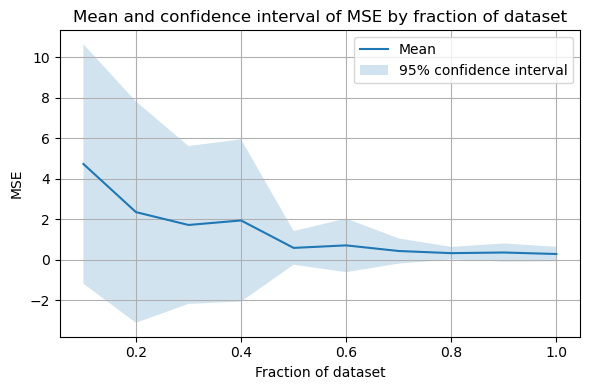

In [11]:
def gen_sample_dataset(data, frac):
    data = data.copy()
    return data.sample(frac=frac).sort_values(by='t').reset_index(drop=True)

def batch_comparison_by_frac(fracs, n_samples=10, optimizer=classic_annealing, objective=mse_objective, initial_conditions=[y[0], x[0]], **kwargs):
    results = []
    with tqdm(total=len(fracs)*n_samples) as pbar:
        for frac in fracs:
            mse = []
            for _ in range(n_samples):
                sample_data = gen_sample_dataset(data, frac)
                params = optimizer(objective, **kwargs).x
                print(f"params: {params}")
                sim_data = solve_lv(params, initial_conditions, sample_data['t'])
                print(f"Minimum and Maximum of sim_data: {sim_data.min()}, {sim_data.max()}")
                mse.append(mean_squared_error(sample_data[['y', 'x']].values, sim_data))
                print(f"MSE: {mean_squared_error(sample_data[['y', 'x']].values, sim_data)}")
                pbar.update()
            mean_mse, std_mse = np.mean(mse), np.std(mse)
            conf_int = sp.stats.norm.interval(0.95, loc=mean_mse, scale=std_mse)
            results.append([frac, mean_mse, std_mse, conf_int])
    return pd.DataFrame(results, columns=['frac', 'mean', 'std', 'conf_int'])

try:
    fracs = np.linspace(0.1, 1.0, 10)
    experiment_df = batch_comparison_by_frac(fracs=fracs, n_samples=20, bounds=bounds, maxiter=MAX_ITER_SA)
except Exception as e:
    print(f"An error occurred: {e}")

plt.figure(figsize=(6, 4), layout='tight')
plt.plot(experiment_df['frac'], experiment_df['mean'], label='Mean')
plt.fill_between(experiment_df['frac'], experiment_df['conf_int'].apply(lambda x: x[0]), experiment_df['conf_int'].apply(lambda x: x[1]), alpha=0.2, label='95% confidence interval')
plt.title('Mean and confidence interval of MSE by fraction of dataset')
plt.xlabel('Fraction of dataset')
plt.ylabel('MSE')
plt.legend(loc='upper right')
plt.grid(True)
plt.savefig('media/frac_conf_mse_sa.png')
plt.show()

In [12]:
def mse_objective(params, data):
    initial_conditions = [data['y'].iloc[0], data['x'].iloc[0]]
    sim_data = solve_lv(params, initial_conditions, data['t'])
    return mean_squared_error(data[['y', 'x']].values, sim_data)

def mae_objective(params, data):
    initial_conditions = [data['y'].iloc[0], data['x'].iloc[0]]
    sim_data = solve_lv(params, initial_conditions, data['t'])
    return mean_absolute_error(data[['y', 'x']].values, sim_data)

In [13]:
def batch_comparison_by_frac(data, fracs, data_variable, n_samples=10,
                             optimizer=classic_annealing,
                             objective=mse_objective,
                             **kwargs):
    results = []
    with tqdm(total=len(fracs) * n_samples) as pbar:
        for frac in fracs:
            mse = []
            for _ in range(n_samples):
                sample_data = gen_sample_dataset(data, frac)
                params = optimizer(lambda params: objective(params, sample_data), **kwargs).x
                print(f"params: {params}")
                initial_conditions = [sample_data['y'].iloc[0], sample_data['x'].iloc[0]]
                sim_data = solve_lv(params, initial_conditions, sample_data['t'])
                print(f"Minimum and Maximum of sim_data: {sim_data.min()}, {sim_data.max()}")
                mse.append(mean_squared_error(sample_data[data_variable].values, sim_data[:, {'y': 0, 'x': 1}[data_variable]]))
                print(f"MSE: {mean_squared_error(sample_data[data_variable].values, sim_data[:, {'y': 0, 'x': 1}[data_variable]])}")
                pbar.update()
            mean_mse, std_mse = np.mean(mse), np.std(mse)
            conf_int = sp.stats.norm.interval(0.95, loc=mean_mse, scale=std_mse)
            results.append([frac, mean_mse, std_mse, conf_int])
    return pd.DataFrame(results, columns=['frac', 'mean', 'std', 'conf_int'])

## Experiments and plots

  0%|▍                                                                                 | 1/200 [00:01<04:35,  1.38s/it]

params: [1.03094497 0.52847436 1.60272981 0.95663476]
Minimum and Maximum of sim_data: 0.27665852725841406, 6.342061282105013
MSE: 0.08322951615929401


  1%|▊                                                                                 | 2/200 [00:02<04:55,  1.49s/it]

params: [1.64893821 0.78220052 1.37528261 1.34274568]
Minimum and Maximum of sim_data: 0.11743557767402964, 7.074856477892268
MSE: 0.23842167157835203


  2%|█▏                                                                                | 3/200 [00:04<04:39,  1.42s/it]

params: [0.90641087 0.55589584 1.82807304 1.00167606]
Minimum and Maximum of sim_data: 0.236231084778616, 4.294585604326472
MSE: 0.08095591724803337


  2%|█▋                                                                                | 4/200 [00:05<04:06,  1.26s/it]

params: [1.42639932 0.65865241 1.06162623 0.57183447]
Minimum and Maximum of sim_data: 0.4828585910211586, 5.362525198335344
MSE: 0.07399505425707996


  2%|██                                                                                | 5/200 [00:06<04:17,  1.32s/it]

params: [1.70611501 1.05395602 1.10584233 0.46699184]
Minimum and Maximum of sim_data: 0.36076869077370965, 3.8285501852300703
MSE: 0.07109299340126418


  3%|██▍                                                                               | 6/200 [00:08<04:25,  1.37s/it]

params: [1.61639553 0.59020271 0.90527962 0.49072214]
Minimum and Maximum of sim_data: 0.6999448036089093, 4.804048109472415
MSE: 0.08195284761487125


  4%|██▊                                                                               | 7/200 [00:09<04:16,  1.33s/it]

params: [1.23460139 0.64215282 1.43934702 0.93528964]
Minimum and Maximum of sim_data: 0.33176087411274885, 5.618882426875939
MSE: 0.09047792026060289


  4%|███▎                                                                              | 8/200 [00:10<04:02,  1.26s/it]

params: [1.14242943 0.80761769 1.48539561 0.76392822]
Minimum and Maximum of sim_data: 0.3852568008404658, 4.543937997597665
MSE: 0.07727087536696328


  4%|███▋                                                                              | 9/200 [00:11<04:02,  1.27s/it]

params: [1.15218761 0.55703314 1.436526   0.67453714]
Minimum and Maximum of sim_data: 0.5057051683260017, 6.002964955579778
MSE: 0.18529103368459138


  5%|████                                                                             | 10/200 [00:13<04:17,  1.36s/it]

params: [1.15921091 0.68176569 1.75164172 1.10560336]
Minimum and Maximum of sim_data: 0.1772514652042841, 6.114004609747
MSE: 0.16228548166260212


  6%|████▍                                                                            | 11/200 [00:14<04:11,  1.33s/it]

params: [0.98160451 0.47734541 1.72509721 1.01027107]
Minimum and Maximum of sim_data: 0.4190407115433935, 6.126408727538915
MSE: 0.011184580663690397


  6%|████▊                                                                            | 12/200 [00:16<04:20,  1.39s/it]

params: [1.00334342 0.66611836 1.74306574 0.867532  ]
Minimum and Maximum of sim_data: 0.1948196623370259, 4.78163509155479
MSE: 0.07960414708236425


  6%|█████▎                                                                           | 13/200 [00:17<04:11,  1.35s/it]

params: [1.44460965 0.93349394 1.07767643 0.65814952]
Minimum and Maximum of sim_data: 0.5451267132401091, 3.5909873147111897
MSE: 0.06627217094870416


  7%|█████▋                                                                           | 14/200 [00:18<04:14,  1.37s/it]

params: [1.13542478 0.94826938 1.79168017 1.12261076]
Minimum and Maximum of sim_data: 0.14952043273939583, 4.5251342898656635
MSE: 0.1738611987107999


  8%|██████                                                                           | 15/200 [00:20<04:02,  1.31s/it]

params: [1.43336508 0.75981466 1.20404069 0.76030607]
Minimum and Maximum of sim_data: 0.3156213952060949, 4.815115782464414
MSE: 0.18831513013859813


  8%|██████▍                                                                          | 16/200 [00:21<04:07,  1.34s/it]

params: [0.90559602 0.50683925 1.87369616 1.04712272]
Minimum and Maximum of sim_data: 0.37116599744002443, 5.08839496680188
MSE: 0.01801887459631089


  8%|██████▉                                                                          | 17/200 [00:22<04:07,  1.35s/it]

params: [1.44890137 0.80901137 1.22382296 0.72747148]
Minimum and Maximum of sim_data: 0.32043233721162157, 5.259703076298574
MSE: 0.4076798207888384


  9%|███████▎                                                                         | 18/200 [00:24<04:04,  1.34s/it]

params: [0.89037351 0.56527165 1.77105653 1.26032813]
Minimum and Maximum of sim_data: 0.23020892423679334, 5.195731675674716
MSE: 0.13349963665918735


 10%|███████▋                                                                         | 19/200 [00:25<04:10,  1.39s/it]

params: [1.14621548 0.53530852 1.46644835 0.89185829]
Minimum and Maximum of sim_data: 0.4722737994430515, 5.766974935796497
MSE: 0.04501190078744412


 10%|████████                                                                         | 20/200 [00:27<04:27,  1.48s/it]

params: [0.88701348 0.4049074  1.8088902  0.98096092]
Minimum and Maximum of sim_data: 0.5021876144336554, 5.8700980615964635
MSE: 0.029070967872551572


 10%|████████▌                                                                        | 21/200 [00:28<04:32,  1.52s/it]

params: [1.05420814 0.49942162 1.63154244 0.8108267 ]
Minimum and Maximum of sim_data: 0.3652232723236143, 6.2961862481271105
MSE: 0.17502577853370344


 11%|████████▉                                                                        | 22/200 [00:30<04:37,  1.56s/it]

params: [1.0429299  0.48087254 1.68931455 1.07239191]
Minimum and Maximum of sim_data: 0.39867934483080764, 6.114004609747
MSE: 0.02427876440010402


 12%|█████████▎                                                                       | 23/200 [00:32<04:34,  1.55s/it]

params: [1.31327993 0.71600914 1.68531084 1.57314116]
Minimum and Maximum of sim_data: 0.12208397938061104, 7.135313060629415
MSE: 0.573675689705427


 12%|█████████▋                                                                       | 24/200 [00:33<04:33,  1.56s/it]

params: [1.07970789 0.57990034 1.5708531  0.89603783]
Minimum and Maximum of sim_data: 0.3102125486457099, 5.74249577441306
MSE: 0.16603126198495094


 12%|██████████▏                                                                      | 25/200 [00:35<04:19,  1.48s/it]

params: [1.31034461 0.88872698 1.21831241 0.66776758]
Minimum and Maximum of sim_data: 0.39623195595081895, 4.548931256667328
MSE: 0.13125754945355542


 13%|██████████▌                                                                      | 26/200 [00:36<04:11,  1.45s/it]

params: [0.97062917 0.5574605  1.82168996 1.02959937]
Minimum and Maximum of sim_data: 0.27565597268214154, 4.598133964506956
MSE: 0.03139093025919695


 14%|██████████▉                                                                      | 27/200 [00:37<04:13,  1.47s/it]

params: [0.78025245 0.35516549 1.99627092 0.98854382]
Minimum and Maximum of sim_data: 0.5464236616662955, 5.660504093695885
MSE: 0.0975465184429429


 14%|███████████▎                                                                     | 28/200 [00:39<04:02,  1.41s/it]

params: [1.17369835 0.60533395 1.43781004 0.76610933]
Minimum and Maximum of sim_data: 0.4207684346223635, 5.304188940630177
MSE: 0.12015215235057479


 14%|███████████▋                                                                     | 29/200 [00:40<04:10,  1.47s/it]

params: [1.12013243 0.93369282 1.78851239 1.22018501]
Minimum and Maximum of sim_data: 0.15299539648736474, 4.093241894168084
MSE: 0.1424092188301293


 15%|████████████▏                                                                    | 30/200 [00:42<04:01,  1.42s/it]

params: [1.47187094 0.61365487 0.972549   0.58206714]
Minimum and Maximum of sim_data: 0.48300236115241085, 4.94006621179057
MSE: 0.22385737389970414


 16%|████████████▌                                                                    | 31/200 [00:43<03:55,  1.39s/it]

params: [0.88964835 0.43388984 1.8743003  1.17289414]
Minimum and Maximum of sim_data: 0.39484191852992717, 5.730109702274695
MSE: 0.028990272685112107


 16%|████████████▉                                                                    | 32/200 [00:44<04:02,  1.44s/it]

params: [1.32101571 0.72012749 1.68107587 1.6289178 ]
Minimum and Maximum of sim_data: 0.10708484325164122, 7.574500867190617
MSE: 0.6645669070605826


 16%|█████████████▎                                                                   | 33/200 [00:46<04:08,  1.49s/it]

params: [0.81519828 0.31898079 1.91064921 1.06144564]
Minimum and Maximum of sim_data: 0.7192641673432145, 6.299123131443379
MSE: 0.117103388646616


 17%|█████████████▊                                                                   | 34/200 [00:47<04:03,  1.47s/it]

params: [1.29435849 0.6466886  1.43611938 0.88649595]
Minimum and Maximum of sim_data: 0.29429971530299154, 6.23836095039208
MSE: 0.12085465846988148


 18%|██████████████▏                                                                  | 35/200 [00:49<03:53,  1.42s/it]

params: [1.13525039 0.57961825 1.44588641 0.82798533]
Minimum and Maximum of sim_data: 0.4794456868161097, 4.939742697941771
MSE: 0.017229953694686283


 18%|██████████████▌                                                                  | 36/200 [00:50<03:49,  1.40s/it]

params: [0.99678222 0.61203578 1.81884461 1.04946918]
Minimum and Maximum of sim_data: 0.24684479830715048, 5.224967458094916
MSE: 0.06379542610533694


 18%|██████████████▉                                                                  | 37/200 [00:52<03:53,  1.43s/it]

params: [1.27753891 0.7719453  1.46819952 1.09020561]
Minimum and Maximum of sim_data: 0.3091850011343184, 4.58254574572571
MSE: 0.15862840055822627


 19%|███████████████▍                                                                 | 38/200 [00:53<03:48,  1.41s/it]

params: [1.37800984 1.07983804 1.46558461 0.78957303]
Minimum and Maximum of sim_data: 0.17925984841782538, 5.175395514050781
MSE: 0.3267173247776857


 20%|███████████████▊                                                                 | 39/200 [00:54<03:40,  1.37s/it]

params: [0.89994904 0.4793291  1.93488173 1.11368652]
Minimum and Maximum of sim_data: 0.2886692160270427, 5.784087428178321
MSE: 0.013129628317267213


 20%|████████████████▏                                                                | 40/200 [00:56<03:49,  1.43s/it]

params: [0.86181661 0.41294613 1.88366781 0.98920207]
Minimum and Maximum of sim_data: 0.4622880260855431, 5.748624028991284
MSE: 0.03164166997929688


 20%|████████████████▌                                                                | 41/200 [00:57<03:55,  1.48s/it]

params: [1.44044334 0.74054794 1.25411883 0.81691509]
Minimum and Maximum of sim_data: 0.2819862010763484, 5.533642157583945
MSE: 0.21968180812269247


 21%|█████████████████                                                                | 42/200 [00:59<03:47,  1.44s/it]

params: [1.35515706 0.55482673 1.26554554 0.82992591]
Minimum and Maximum of sim_data: 0.3507556652968818, 6.3828067997835225
MSE: 0.09131452557207576


 22%|█████████████████▍                                                               | 43/200 [01:00<03:52,  1.48s/it]

params: [1.42265183 0.75413912 1.30620772 0.89299701]
Minimum and Maximum of sim_data: 0.23156183683769274, 5.655103618182058
MSE: 0.20226928602665448


 22%|█████████████████▊                                                               | 44/200 [01:02<03:48,  1.47s/it]

params: [1.13419499 0.49211391 1.48636576 0.92270371]
Minimum and Maximum of sim_data: 0.4585021401270433, 6.24716345546429
MSE: 0.028252762785957123


 22%|██████████████████▏                                                              | 45/200 [01:03<03:45,  1.45s/it]

params: [1.3461097  0.85628052 1.35400443 0.7034049 ]
Minimum and Maximum of sim_data: 0.32619964772557625, 4.356570586495013
MSE: 0.08388884817965328


 23%|██████████████████▋                                                              | 46/200 [01:05<03:48,  1.48s/it]

params: [1.43609292 0.73661731 1.44290707 1.12125038]
Minimum and Maximum of sim_data: 0.17264624209504173, 6.568221381436903
MSE: 0.27132479574417717


 24%|███████████████████                                                              | 47/200 [01:06<03:49,  1.50s/it]

params: [1.18977465 0.54118279 1.64271104 1.41097647]
Minimum and Maximum of sim_data: 0.23612984327092176, 7.242267708828658
MSE: 0.31540142692107426


 24%|███████████████████▍                                                             | 48/200 [01:08<03:51,  1.52s/it]

params: [1.10818883 0.66189377 1.72510996 1.12942523]
Minimum and Maximum of sim_data: 0.19348342616576417, 5.916426897719668
MSE: 0.10850037244459053


 24%|███████████████████▊                                                             | 49/200 [01:10<04:01,  1.60s/it]

params: [1.0516987  0.49009047 1.62558082 0.98784008]
Minimum and Maximum of sim_data: 0.44928241027992344, 5.52052404752254
MSE: 0.014118459786579489


 25%|████████████████████▎                                                            | 50/200 [01:11<03:59,  1.60s/it]

params: [1.34200592 0.6004069  1.33001845 0.96327059]
Minimum and Maximum of sim_data: 0.2901353144302129, 6.274022634897243
MSE: 0.16389406965607314


 26%|████████████████████▋                                                            | 51/200 [01:13<04:01,  1.62s/it]

params: [1.3125637  0.77854642 1.70852553 1.59034192]
Minimum and Maximum of sim_data: 0.10943356185685339, 7.095012500503027
MSE: 0.5616064456625713


 26%|█████████████████████                                                            | 52/200 [01:15<03:58,  1.61s/it]

params: [1.23886898 0.52576003 1.63394759 1.47479046]
Minimum and Maximum of sim_data: 0.18125747396607864, 6.778576811286703
MSE: 0.36659471789904585


 26%|█████████████████████▍                                                           | 53/200 [01:16<03:43,  1.52s/it]

params: [0.93890939 0.48213583 1.86387862 1.00979287]
Minimum and Maximum of sim_data: 0.2959511808889005, 6.115791144305521
MSE: 0.0376060136908136


 27%|█████████████████████▊                                                           | 54/200 [01:17<03:43,  1.53s/it]

params: [0.9400167  0.40422993 1.80316314 1.14436404]
Minimum and Maximum of sim_data: 0.4857626839825879, 6.476220660956191
MSE: 0.043625958525857995


 28%|██████████████████████▎                                                          | 55/200 [01:19<03:38,  1.51s/it]

params: [1.56271167 0.91426565 1.22125246 0.79981344]
Minimum and Maximum of sim_data: 0.2474891816109637, 4.778204486991222
MSE: 0.2695504705568794


 28%|██████████████████████▋                                                          | 56/200 [01:20<03:36,  1.50s/it]

params: [1.20355539 0.5520059  1.44956618 0.99844847]
Minimum and Maximum of sim_data: 0.3462360350151404, 6.23836095039208
MSE: 0.12254977048698058


 28%|███████████████████████                                                          | 57/200 [01:22<03:31,  1.48s/it]

params: [1.10846426 0.50398907 1.48784375 0.73153349]
Minimum and Maximum of sim_data: 0.5935834461295898, 5.516146966071418
MSE: 0.2861046213175153


 29%|███████████████████████▍                                                         | 58/200 [01:23<03:29,  1.47s/it]

params: [1.16325305 0.71002162 1.87567514 1.5721219 ]
Minimum and Maximum of sim_data: 0.10630387087303753, 7.022331500778748
MSE: 0.28295919560683086


 30%|███████████████████████▉                                                         | 59/200 [01:25<03:33,  1.51s/it]

params: [1.2296154  0.79656588 1.66390264 1.14931131]
Minimum and Maximum of sim_data: 0.1471418401645183, 5.812845327778346
MSE: 0.22813634276584197


 30%|████████████████████████▎                                                        | 60/200 [01:26<03:25,  1.47s/it]

params: [1.48752633 0.88530962 1.20783065 0.74191166]
Minimum and Maximum of sim_data: 0.37303390160679567, 4.384811873854751
MSE: 0.11300323986551856


 30%|████████████████████████▋                                                        | 61/200 [01:28<03:23,  1.47s/it]

params: [1.24419458 0.59965592 1.48595865 1.03769333]
Minimum and Maximum of sim_data: 0.27964505863968847, 6.264359359726274
MSE: 0.14841574405631863


 31%|█████████████████████████                                                        | 62/200 [01:29<03:23,  1.47s/it]

params: [0.96716514 0.51542288 1.86413596 1.11959472]
Minimum and Maximum of sim_data: 0.2536904912635732, 6.23836095039208
MSE: 0.033098161785594535


 32%|█████████████████████████▌                                                       | 63/200 [01:31<03:25,  1.50s/it]

params: [1.08715588 0.67834709 1.9179875  1.43959329]
Minimum and Maximum of sim_data: 0.11709004672242102, 6.568072730926499
MSE: 0.24274638054194728


 32%|█████████████████████████▉                                                       | 64/200 [01:32<03:21,  1.48s/it]

params: [1.21233849 0.52351216 1.4061689  0.93043853]
Minimum and Maximum of sim_data: 0.39798296301931013, 6.167664791625402
MSE: 0.0801689847081712


 32%|██████████████████████████▎                                                      | 65/200 [01:34<03:19,  1.47s/it]

params: [1.25929992 0.70287705 1.3991426  0.79203807]
Minimum and Maximum of sim_data: 0.3268624811121637, 5.3069446465268975
MSE: 0.12123307014823197


 33%|██████████████████████████▋                                                      | 66/200 [01:35<03:18,  1.48s/it]

params: [1.16571966 0.59406677 1.48889596 0.9049966 ]
Minimum and Maximum of sim_data: 0.3764369293782257, 5.695841649332164
MSE: 0.05286993109827139


 34%|███████████████████████████▏                                                     | 67/200 [01:37<03:19,  1.50s/it]

params: [1.51634283 1.01687792 1.40847377 0.99976367]
Minimum and Maximum of sim_data: 0.1254649147813924, 5.476000111427042
MSE: 0.4961807360415028


 34%|███████████████████████████▌                                                     | 68/200 [01:38<03:16,  1.49s/it]

params: [1.00077247 0.39639869 1.58531848 0.88995011]
Minimum and Maximum of sim_data: 0.6617731371286991, 6.268299716207326
MSE: 0.02040294832847508


 34%|███████████████████████████▉                                                     | 69/200 [01:40<03:24,  1.56s/it]

params: [1.535049   1.17305544 1.54508956 1.15046532]
Minimum and Maximum of sim_data: 0.08440048650323737, 5.691405833762612
MSE: 0.7694184616844175


 35%|████████████████████████████▎                                                    | 70/200 [01:41<03:18,  1.52s/it]

params: [1.10845982 0.56410665 1.67682529 1.65943233]
Minimum and Maximum of sim_data: 0.21614476806025748, 6.579014007502651
MSE: 0.7943971773779206


 36%|████████████████████████████▊                                                    | 71/200 [01:43<03:17,  1.53s/it]

params: [1.12931408 0.57155963 1.62794422 1.12245276]
Minimum and Maximum of sim_data: 0.2996124162782425, 6.249963353387209
MSE: 0.09356938998371087


 36%|█████████████████████████████▏                                                   | 72/200 [01:44<03:10,  1.48s/it]

params: [1.48987    0.6583635  1.16238773 0.65499931]
Minimum and Maximum of sim_data: 0.3499189354783171, 5.930075511916403
MSE: 0.21263320286729778


 36%|█████████████████████████████▌                                                   | 73/200 [01:46<03:11,  1.51s/it]

params: [1.18979587 0.69118544 1.71442939 1.34972427]
Minimum and Maximum of sim_data: 0.1542335603697314, 6.627583618182003
MSE: 0.3411928708302271


 37%|█████████████████████████████▉                                                   | 74/200 [01:47<03:10,  1.52s/it]

params: [1.03445991 0.49480827 1.61493686 0.7916183 ]
Minimum and Maximum of sim_data: 0.3978714805471658, 6.126373386598078
MSE: 0.2328053383868534


 38%|██████████████████████████████▍                                                  | 75/200 [01:49<03:11,  1.54s/it]

params: [1.54288702 0.73614141 1.32065876 1.24315236]
Minimum and Maximum of sim_data: 0.11382717916082552, 7.010381486439142
MSE: 0.49225502924536596


 38%|██████████████████████████████▊                                                  | 76/200 [01:50<03:06,  1.51s/it]

params: [0.92089624 0.4063954  1.71997594 0.93834509]
Minimum and Maximum of sim_data: 0.5593479375718116, 5.8750424031936905
MSE: 0.04346880473768729


 38%|███████████████████████████████▏                                                 | 77/200 [01:52<03:10,  1.55s/it]

params: [1.15378094 0.71414682 1.7588083  1.28742284]
Minimum and Maximum of sim_data: 0.14191144636684597, 6.2372138014002
MSE: 0.21413823307012153


 39%|███████████████████████████████▌                                                 | 78/200 [01:54<03:08,  1.54s/it]

params: [1.39153464 0.54825904 1.19826184 0.6875677 ]
Minimum and Maximum of sim_data: 0.4214330888022797, 6.23836095039208
MSE: 0.08607608378875259


 40%|███████████████████████████████▉                                                 | 79/200 [01:55<03:05,  1.53s/it]

params: [1.30775939 0.70612428 1.42439353 1.00510799]
Minimum and Maximum of sim_data: 0.23815130827987863, 5.952110854563107
MSE: 0.20931788528387338


 40%|████████████████████████████████▍                                                | 80/200 [01:57<03:06,  1.55s/it]

params: [1.05897744 0.82448145 1.9935909  1.2617727 ]
Minimum and Maximum of sim_data: 0.07388810619790774, 5.62243488707062
MSE: 0.22808241019681535


 40%|████████████████████████████████▊                                                | 81/200 [01:58<02:56,  1.49s/it]

params: [1.5550117  0.48105839 0.98464623 0.7071579 ]
Minimum and Maximum of sim_data: 0.46403860988140605, 6.23836095039208
MSE: 0.16328079378863808


 41%|█████████████████████████████████▏                                               | 82/200 [02:00<02:57,  1.51s/it]

params: [1.18164495 0.9160581  1.96004838 1.48439216]
Minimum and Maximum of sim_data: 0.05660285439060684, 6.0908631222401155
MSE: 0.3915564695971215


 42%|█████████████████████████████████▌                                               | 83/200 [02:01<02:58,  1.52s/it]

params: [1.0646445  0.51879689 1.57979545 0.90768053]
Minimum and Maximum of sim_data: 0.4367238844405523, 5.704382002015123
MSE: 0.01371379643100885


 42%|██████████████████████████████████                                               | 84/200 [02:03<02:54,  1.50s/it]

params: [1.31836672 0.60712586 1.35740259 0.83617747]
Minimum and Maximum of sim_data: 0.3255317492826609, 6.23409091645064
MSE: 0.10801730015243302


 42%|██████████████████████████████████▍                                              | 85/200 [02:04<02:51,  1.49s/it]

params: [1.70877508 0.80113476 1.14706618 0.77425272]
Minimum and Maximum of sim_data: 0.1722080462527486, 6.23836095039208
MSE: 0.31076547773703467


 43%|██████████████████████████████████▊                                              | 86/200 [02:06<02:53,  1.52s/it]

params: [1.94439245 0.96881858 0.91729752 0.49097787]
Minimum and Maximum of sim_data: 0.2272756148108468, 6.4755093429828445
MSE: 0.7447612698163789


 44%|███████████████████████████████████▏                                             | 87/200 [02:07<02:50,  1.51s/it]

params: [1.22095542 0.84637652 1.84072368 1.30281018]
Minimum and Maximum of sim_data: 0.08764893378877865, 6.23836095039208
MSE: 0.38627020847901006


 44%|███████████████████████████████████▋                                             | 88/200 [02:09<02:50,  1.52s/it]

params: [1.9514549  1.1240729  1.23112572 1.03259592]
Minimum and Maximum of sim_data: 0.055823187415626044, 6.23836095039208
MSE: 0.7979750950384609


 44%|████████████████████████████████████                                             | 89/200 [02:10<02:48,  1.52s/it]

params: [1.39842254 0.58977155 1.26077744 0.91997744]
Minimum and Maximum of sim_data: 0.30452652398407903, 6.23836095039208
MSE: 0.17685121273578996


 45%|████████████████████████████████████▍                                            | 90/200 [02:12<02:47,  1.52s/it]

params: [1.66443113 0.6325418  0.99883019 0.51735321]
Minimum and Maximum of sim_data: 0.3864867332178814, 6.131253454600371
MSE: 0.33796965870443635


 46%|████████████████████████████████████▊                                            | 91/200 [02:13<02:43,  1.50s/it]

params: [1.03629664 0.40651818 1.53564812 0.87937829]
Minimum and Maximum of sim_data: 0.6264803014181549, 6.31724123240675
MSE: 0.02553997412275404


 46%|█████████████████████████████████████▎                                           | 92/200 [02:15<02:42,  1.51s/it]

params: [1.11863281 0.7125103  1.86124438 1.18929516]
Minimum and Maximum of sim_data: 0.12107089352030133, 6.334745330005711
MSE: 0.1920571160623553


 46%|█████████████████████████████████████▋                                           | 93/200 [02:16<02:41,  1.51s/it]

params: [0.96627876 0.50835377 1.99521607 1.48182911]
Minimum and Maximum of sim_data: 0.17007511757094296, 7.291513697677268
MSE: 0.19270836002512343


C:\conda\lib\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
 47%|██████████████████████████████████████                                           | 94/200 [02:18<02:42,  1.53s/it]

params: [1.12554611 0.81640912 1.85904153 1.23211206]
Minimum and Maximum of sim_data: 0.09528106852851811, 5.745592570622948
MSE: 0.22934694899699143


 48%|██████████████████████████████████████▍                                          | 95/200 [02:19<02:40,  1.53s/it]

params: [0.96710181 0.46165693 1.75006232 1.08134847]
Minimum and Maximum of sim_data: 0.37771505802335975, 6.260842330042182
MSE: 0.038980367216553964


 48%|██████████████████████████████████████▉                                          | 96/200 [02:21<02:34,  1.49s/it]

params: [1.73963332 0.79068391 1.11621514 0.77348793]
Minimum and Maximum of sim_data: 0.1662312618095608, 6.333129089932892
MSE: 0.3047916227822083


 48%|███████████████████████████████████████▎                                         | 97/200 [02:22<02:29,  1.45s/it]

params: [0.92721599 0.47325509 1.82219993 0.94855645]
Minimum and Maximum of sim_data: 0.3628460019934364, 5.752901541413891
MSE: 0.036262321259113


 49%|███████████████████████████████████████▋                                         | 98/200 [02:24<02:29,  1.47s/it]

params: [0.90454736 0.4786918  1.93479935 1.15118338]
Minimum and Maximum of sim_data: 0.2786707326931725, 6.028566944375714
MSE: 0.016538643273926325


 50%|████████████████████████████████████████                                         | 99/200 [02:25<02:30,  1.49s/it]

params: [1.32080442 0.82125601 1.66078323 1.42041387]
Minimum and Maximum of sim_data: 0.1173948818545563, 6.360989411148135
MSE: 0.4206215796393483


 50%|████████████████████████████████████████                                        | 100/200 [02:27<02:27,  1.48s/it]

params: [1.06833017 0.55431508 1.74457763 1.20760693]
Minimum and Maximum of sim_data: 0.25412704613956466, 6.502782491544995
MSE: 0.10239304408690066


 50%|████████████████████████████████████████▍                                       | 101/200 [02:28<02:29,  1.51s/it]

params: [1.22141354 0.65491851 1.52253495 0.9725878 ]
Minimum and Maximum of sim_data: 0.30779882969030903, 5.7750134674381455
MSE: 0.1775248973179982


 51%|████████████████████████████████████████▊                                       | 102/200 [02:30<02:26,  1.50s/it]

params: [1.28493113 0.65475146 1.47865421 1.06285038]
Minimum and Maximum of sim_data: 0.2285203462932997, 6.480691787761633
MSE: 0.22042693094648858


 52%|█████████████████████████████████████████▏                                      | 103/200 [02:31<02:25,  1.50s/it]

params: [1.25593129 0.5536038  1.27305602 0.7088507 ]
Minimum and Maximum of sim_data: 0.5251169459236146, 5.464483472879769
MSE: 0.035931725919304686


 52%|█████████████████████████████████████████▌                                      | 104/200 [02:33<02:28,  1.55s/it]

params: [1.42788165 0.8072495  1.44160736 1.18097239]
Minimum and Maximum of sim_data: 0.1404012898070828, 6.295663990967933
MSE: 0.38097197860954596


 52%|██████████████████████████████████████████                                      | 105/200 [02:34<02:26,  1.54s/it]

params: [0.96492392 0.48588441 1.88436541 1.29944941]
Minimum and Maximum of sim_data: 0.2657443569814944, 6.662535003698491
MSE: 0.10723651581312264


 53%|██████████████████████████████████████████▍                                     | 106/200 [02:36<02:22,  1.52s/it]

params: [0.96211312 0.45879702 1.66527496 0.8625724 ]
Minimum and Maximum of sim_data: 0.5060327550670053, 5.514840462351921
MSE: 0.04401167159105842


 54%|██████████████████████████████████████████▊                                     | 107/200 [02:37<02:21,  1.52s/it]

params: [1.32578269 0.72173087 1.33149095 0.78568563]
Minimum and Maximum of sim_data: 0.32198848932102586, 5.378822410412502
MSE: 0.1520779408404037


 54%|███████████████████████████████████████████▏                                    | 108/200 [02:39<02:18,  1.51s/it]

params: [1.2980209  0.56860144 1.2995935  0.8642404 ]
Minimum and Maximum of sim_data: 0.3591765585420314, 6.02696501447956
MSE: 0.10341546485577907


 55%|███████████████████████████████████████████▌                                    | 109/200 [02:40<02:20,  1.54s/it]

params: [0.97700118 0.52130966 1.68052944 0.88587428]
Minimum and Maximum of sim_data: 0.36284919716615655, 5.393023258013316
MSE: 0.06932688342308099


 55%|████████████████████████████████████████████                                    | 110/200 [02:42<02:20,  1.56s/it]

params: [1.48996937 0.80896409 1.41877828 1.10245239]
Minimum and Maximum of sim_data: 0.13712161857936545, 6.534705001675893
MSE: 0.36947355186620534


 56%|████████████████████████████████████████████▍                                   | 111/200 [02:43<02:17,  1.54s/it]

params: [0.95344549 0.53034644 1.92185991 1.23731414]
Minimum and Maximum of sim_data: 0.21231278867619852, 6.308197591330996
MSE: 0.06449148706881681


 56%|████████████████████████████████████████████▊                                   | 112/200 [02:45<02:15,  1.54s/it]

params: [1.56209232 0.68559374 1.11914622 0.76185559]
Minimum and Maximum of sim_data: 0.2834768678874796, 5.761124398008815
MSE: 0.1465568907366516


 56%|█████████████████████████████████████████████▏                                  | 113/200 [02:47<02:14,  1.54s/it]

params: [0.98070854 0.55174826 1.97232108 1.38607354]
Minimum and Maximum of sim_data: 0.1676300197370276, 6.71180458954589
MSE: 0.13003206000790954


 57%|█████████████████████████████████████████████▌                                  | 114/200 [02:48<02:12,  1.54s/it]

params: [1.70124254 0.96550835 1.18191743 0.88553213]
Minimum and Maximum of sim_data: 0.1223206230492153, 5.604281633045273
MSE: 0.4580601646772873


 57%|██████████████████████████████████████████████                                  | 115/200 [02:50<02:09,  1.52s/it]

params: [1.7090621  0.75174917 1.10729311 0.77034442]
Minimum and Maximum of sim_data: 0.18473786882637497, 6.349131134845363
MSE: 0.31662389648289746


 58%|██████████████████████████████████████████████▍                                 | 116/200 [02:51<02:08,  1.53s/it]

params: [1.48710537 0.69594869 1.11868474 0.63985377]
Minimum and Maximum of sim_data: 0.37259454505509915, 5.296624302424842
MSE: 0.1501868098221201


 58%|██████████████████████████████████████████████▊                                 | 117/200 [02:53<02:04,  1.49s/it]

params: [1.00217376 0.683475   1.74665963 1.16243443]
Minimum and Maximum of sim_data: 0.27085929618159793, 4.345948569114713
MSE: 0.1071048364875291


 59%|███████████████████████████████████████████████▏                                | 118/200 [02:54<02:10,  1.60s/it]

params: [1.54842595 1.14587903 1.66155746 1.51850393]
Minimum and Maximum of sim_data: 0.06106241072109858, 6.232578918762824
MSE: 0.606972553856849


 60%|███████████████████████████████████████████████▌                                | 119/200 [02:56<02:06,  1.56s/it]

params: [0.98066002 0.43735424 1.65688777 0.87477896]
Minimum and Maximum of sim_data: 0.48816993226302313, 6.151819194415628
MSE: 0.03265603071239358


 60%|████████████████████████████████████████████████                                | 120/200 [02:57<02:04,  1.56s/it]

params: [1.93440238 0.93056141 1.09005996 1.07183034]
Minimum and Maximum of sim_data: 0.07189512199246516, 6.429461893258532
MSE: 0.6570452747314702


 60%|████████████████████████████████████████████████▍                               | 121/200 [02:59<02:03,  1.57s/it]

params: [1.4504873  0.67859031 1.31771336 1.08267874]
Minimum and Maximum of sim_data: 0.18078918365305643, 6.594882075987615
MSE: 0.34056220559792016


 61%|████████████████████████████████████████████████▊                               | 122/200 [03:01<02:02,  1.58s/it]

params: [1.4122968  0.94955584 1.59164384 1.33411095]
Minimum and Maximum of sim_data: 0.10259318666542794, 6.17232491179144
MSE: 0.5238238943251353


 62%|█████████████████████████████████████████████████▏                              | 123/200 [03:02<02:00,  1.56s/it]

params: [1.11231164 0.66090467 1.94090708 1.64362472]
Minimum and Maximum of sim_data: 0.09923911315408275, 7.306012627255957
MSE: 0.41232051047275736


 62%|█████████████████████████████████████████████████▌                              | 124/200 [03:04<01:56,  1.54s/it]

params: [0.96584129 0.45313102 1.76383687 1.04718641]
Minimum and Maximum of sim_data: 0.3891321054669414, 6.297822047291481
MSE: 0.012003739282607746


 62%|██████████████████████████████████████████████████                              | 125/200 [03:05<01:53,  1.51s/it]

params: [0.88186533 0.44893823 1.95531312 1.11380994]
Minimum and Maximum of sim_data: 0.2987402080631432, 6.256034118542559
MSE: 0.01087397502361932


 63%|██████████████████████████████████████████████████▍                             | 126/200 [03:06<01:49,  1.48s/it]

params: [1.46042438 0.56489342 1.03052824 0.51066013]
Minimum and Maximum of sim_data: 0.6763051245721096, 5.139150656430222
MSE: 0.10674748340526057


 64%|██████████████████████████████████████████████████▊                             | 127/200 [03:08<01:48,  1.49s/it]

params: [1.69271423 0.81607854 1.06034477 0.68679057]
Minimum and Maximum of sim_data: 0.23342549782470037, 5.414032680234932
MSE: 0.2488169672371256


 64%|███████████████████████████████████████████████████▏                            | 128/200 [03:09<01:46,  1.48s/it]

params: [0.9097248  0.4268421  1.81612341 0.99277815]
Minimum and Maximum of sim_data: 0.4057678910686683, 6.225705779816489
MSE: 0.017680086764963913


 64%|███████████████████████████████████████████████████▌                            | 129/200 [03:11<01:44,  1.47s/it]

params: [1.08547041 0.62192205 1.78182247 1.08718947]
Minimum and Maximum of sim_data: 0.19428742118140613, 6.23836095039208
MSE: 0.09457770179990713


 65%|████████████████████████████████████████████████████                            | 130/200 [03:12<01:46,  1.51s/it]

params: [1.63384241 0.79329905 1.11818334 0.82702554]
Minimum and Maximum of sim_data: 0.18277843945223501, 5.788112019951477
MSE: 0.36737709632996185


 66%|████████████████████████████████████████████████████▍                           | 131/200 [03:14<01:45,  1.52s/it]

params: [1.27689664 0.74748248 1.6338205  1.33412537]
Minimum and Maximum of sim_data: 0.15354118213905565, 6.571739995219781
MSE: 0.34316438904008006


 66%|████████████████████████████████████████████████████▊                           | 132/200 [03:15<01:43,  1.52s/it]

params: [1.39474259 0.81582715 1.46527105 1.13553506]
Minimum and Maximum of sim_data: 0.15699358218937084, 6.079416716706525
MSE: 0.3431722722324481


 66%|█████████████████████████████████████████████████████▏                          | 133/200 [03:17<01:42,  1.52s/it]

params: [1.391925   0.88052586 1.64261516 1.34515395]
Minimum and Maximum of sim_data: 0.10698596906774833, 6.632345224963045
MSE: 0.48181452923642454


 67%|█████████████████████████████████████████████████████▌                          | 134/200 [03:19<01:40,  1.52s/it]

params: [0.9966106  0.4714304  1.91596051 1.41705385]
Minimum and Maximum of sim_data: 0.24133557875496128, 7.503331142381209
MSE: 0.16062518697915698


 68%|██████████████████████████████████████████████████████                          | 135/200 [03:20<01:38,  1.51s/it]

params: [1.70658361 0.81943026 1.05105464 0.6879257 ]
Minimum and Maximum of sim_data: 0.22716337556286365, 5.431480776029006
MSE: 0.2573345986242547


 68%|██████████████████████████████████████████████████████▍                         | 136/200 [03:22<01:36,  1.50s/it]

params: [1.65180942 0.94721458 1.35563208 1.10602604]
Minimum and Maximum of sim_data: 0.09847201202838307, 6.23836095039208
MSE: 0.4930761037813044


 68%|██████████████████████████████████████████████████████▊                         | 137/200 [03:23<01:37,  1.54s/it]

params: [1.23190624 0.92093241 1.97655476 1.70409632]
Minimum and Maximum of sim_data: 0.04864972899571049, 6.607396414494713
MSE: 0.5446112055439978


 69%|███████████████████████████████████████████████████████▏                        | 138/200 [03:25<01:36,  1.55s/it]

params: [1.39980201 0.74116849 1.46862886 1.25721399]
Minimum and Maximum of sim_data: 0.14448442795895833, 6.6884769637977675
MSE: 0.41640763595093955


 70%|███████████████████████████████████████████████████████▌                        | 139/200 [03:26<01:34,  1.55s/it]

params: [1.15238075 0.69969645 1.82250584 1.43376635]
Minimum and Maximum of sim_data: 0.12606920068016358, 6.67804491623855
MSE: 0.2834081872780067


 70%|████████████████████████████████████████████████████████                        | 140/200 [03:28<01:31,  1.53s/it]

params: [0.80484052 0.39303671 1.9235299  0.9085602 ]
Minimum and Maximum of sim_data: 0.494439105311907, 5.334838326000557
MSE: 0.17432826891095418


 70%|████████████████████████████████████████████████████████▍                       | 141/200 [03:29<01:31,  1.55s/it]

params: [1.85721497 0.91868056 1.17125943 1.05927091]
Minimum and Maximum of sim_data: 0.07552216440768346, 6.656857852099534
MSE: 0.6436311865445488


 71%|████████████████████████████████████████████████████████▊                       | 142/200 [03:31<01:29,  1.54s/it]

params: [1.88378217 0.83870426 1.0024264  0.80158591]
Minimum and Maximum of sim_data: 0.14979107584740906, 5.897849744722485
MSE: 0.3790659362652435


 72%|█████████████████████████████████████████████████████████▏                      | 143/200 [03:32<01:28,  1.55s/it]

params: [1.39842119 0.96191654 1.55111848 1.14274915]
Minimum and Maximum of sim_data: 0.12008500910948945, 5.742758829001629
MSE: 0.43111062489857666


 72%|█████████████████████████████████████████████████████████▌                      | 144/200 [03:34<01:26,  1.55s/it]

params: [1.21569032 0.71779715 1.82319105 1.62841727]
Minimum and Maximum of sim_data: 0.10367670053980728, 7.31422848770745
MSE: 0.4697065122499354


 72%|██████████████████████████████████████████████████████████                      | 145/200 [03:36<01:26,  1.57s/it]

params: [0.94295758 0.57826935 1.85752895 0.87486128]
Minimum and Maximum of sim_data: 0.2590117454244433, 5.126876357806956
MSE: 0.33090333019002555


 73%|██████████████████████████████████████████████████████████▍                     | 146/200 [03:37<01:24,  1.57s/it]

params: [0.77233562 0.27667526 1.96304691 0.96022131]
Minimum and Maximum of sim_data: 0.9740688187440241, 6.087530822085118
MSE: 0.23261729254554728


 74%|██████████████████████████████████████████████████████████▊                     | 147/200 [03:39<01:22,  1.56s/it]

params: [1.07202607 0.43570387 1.52473087 0.97481691]
Minimum and Maximum of sim_data: 0.49480555717718216, 6.4788197351944286
MSE: 0.06275234751061387


 74%|███████████████████████████████████████████████████████████▏                    | 148/200 [03:40<01:18,  1.52s/it]

params: [0.82112123 0.34176615 1.86969982 0.93765592]
Minimum and Maximum of sim_data: 0.6915406089026637, 5.806356342126034
MSE: 0.11834274005826866


 74%|███████████████████████████████████████████████████████████▌                    | 149/200 [03:42<01:18,  1.54s/it]

params: [1.35297867 0.73316769 1.70973334 1.7465192 ]
Minimum and Maximum of sim_data: 0.09041598759436764, 7.969124150010947
MSE: 0.6865775581690217


 75%|████████████████████████████████████████████████████████████                    | 150/200 [03:43<01:17,  1.54s/it]

params: [1.45419048 1.03238437 1.69163716 1.1925858 ]
Minimum and Maximum of sim_data: 0.07391082006287157, 6.3295494206421345
MSE: 0.64194069094241


 76%|████████████████████████████████████████████████████████████▍                   | 151/200 [03:45<01:13,  1.50s/it]

params: [0.74649669 0.35785365 1.97366529 0.85910843]
Minimum and Maximum of sim_data: 0.566411266660947, 5.186389566064992
MSE: 0.34764166725705115


 76%|████████████████████████████████████████████████████████████▊                   | 152/200 [03:46<01:12,  1.52s/it]

params: [1.16328798 0.68605001 1.8514133  1.56297161]
Minimum and Maximum of sim_data: 0.113930092192481, 7.138061575898627
MSE: 0.37005375152406683


 76%|█████████████████████████████████████████████████████████████▏                  | 153/200 [03:48<01:10,  1.51s/it]

params: [1.19585568 0.60991869 1.41733156 0.74885427]
Minimum and Maximum of sim_data: 0.44902549419004084, 5.272041959811397
MSE: 0.10574074455483642


 77%|█████████████████████████████████████████████████████████████▌                  | 154/200 [03:49<01:09,  1.51s/it]

params: [1.15505858 0.47124877 1.34195917 0.70795421]
Minimum and Maximum of sim_data: 0.6912808380777101, 5.488701451384732
MSE: 0.035834564624544096


 78%|██████████████████████████████████████████████████████████████                  | 155/200 [03:51<01:08,  1.53s/it]

params: [1.38619933 0.86064314 1.54493573 1.32839192]
Minimum and Maximum of sim_data: 0.11150039379072765, 6.420256148143379
MSE: 0.5750398195337658


 78%|██████████████████████████████████████████████████████████████▍                 | 156/200 [03:52<01:06,  1.52s/it]

params: [1.11217813 0.76135815 1.84704233 1.26665268]
Minimum and Maximum of sim_data: 0.10946266451115678, 5.938603537431709
MSE: 0.2053427475527287


 78%|██████████████████████████████████████████████████████████████▊                 | 157/200 [03:54<01:05,  1.53s/it]

params: [1.28258891 0.85861077 1.49031165 0.80060156]
Minimum and Maximum of sim_data: 0.18723313029337688, 5.9316633388043485
MSE: 0.4576680675960863


 79%|███████████████████████████████████████████████████████████████▏                | 158/200 [03:55<01:05,  1.55s/it]

params: [1.75989132 0.92713366 1.08550175 0.6978275 ]
Minimum and Maximum of sim_data: 0.18524769988258197, 5.4410325504582175
MSE: 0.40488092997390446


 80%|███████████████████████████████████████████████████████████████▌                | 159/200 [03:57<01:04,  1.56s/it]

params: [1.30841818 0.65754094 1.50633711 1.24259937]
Minimum and Maximum of sim_data: 0.18338121826513087, 6.8326233194258
MSE: 0.3436820714671313


 80%|████████████████████████████████████████████████████████████████                | 160/200 [03:59<01:01,  1.54s/it]

params: [1.62602332 0.68946271 1.06819443 0.75280407]
Minimum and Maximum of sim_data: 0.26437674378369075, 5.820982964845334
MSE: 0.15281485659358346


 80%|████████████████████████████████████████████████████████████████▍               | 161/200 [04:00<01:00,  1.56s/it]

params: [1.39983164 0.87422587 1.77478805 1.85966568]
Minimum and Maximum of sim_data: 0.06695865314076871, 7.601251036112557
MSE: 0.7667330233229759


 81%|████████████████████████████████████████████████████████████████▊               | 162/200 [04:02<00:59,  1.58s/it]

params: [1.84190589 1.29003429 1.33862011 1.14512875]
Minimum and Maximum of sim_data: 0.049179245701982566, 5.6934751556571594
MSE: 0.8132298850893126


 82%|█████████████████████████████████████████████████████████████████▏              | 163/200 [04:03<00:57,  1.54s/it]

params: [0.97696    0.40921915 1.56847193 0.81240277]
Minimum and Maximum of sim_data: 0.7198325642591927, 5.62537301138359
MSE: 0.06716831674148159


 82%|█████████████████████████████████████████████████████████████████▌              | 164/200 [04:05<00:55,  1.55s/it]

params: [1.17437167 0.77405848 1.76334865 1.25519979]
Minimum and Maximum of sim_data: 0.12352584953266565, 6.019923885853044
MSE: 0.2337325151639133


 82%|██████████████████████████████████████████████████████████████████              | 165/200 [04:06<00:54,  1.55s/it]

params: [1.71201315 0.77286046 1.0083848  0.640847  ]
Minimum and Maximum of sim_data: 0.27066385715989166, 5.394514256647357
MSE: 0.187395309802071


 83%|██████████████████████████████████████████████████████████████████▍             | 166/200 [04:08<00:53,  1.56s/it]

params: [1.89542644 0.72859792 0.86176357 0.53756958]
Minimum and Maximum of sim_data: 0.3415593502882846, 5.397975392802569
MSE: 0.09857069649686745


 84%|██████████████████████████████████████████████████████████████████▊             | 167/200 [04:10<00:52,  1.58s/it]

params: [1.76785144 1.14531942 1.34726634 1.27290352]
Minimum and Maximum of sim_data: 0.051070334244463826, 6.111410899521783
MSE: 0.7919910463713384


 84%|███████████████████████████████████████████████████████████████████▏            | 168/200 [04:11<00:49,  1.55s/it]

params: [1.26980437 0.65676896 1.31275067 0.70147586]
Minimum and Maximum of sim_data: 0.4385750395956581, 5.230688778856086
MSE: 0.1669002028188886


 84%|███████████████████████████████████████████████████████████████████▌            | 169/200 [04:12<00:47,  1.53s/it]

params: [1.03378775 0.56399146 1.66305814 0.9444562 ]
Minimum and Maximum of sim_data: 0.3132861341509184, 5.599605317715551
MSE: 0.04167683661117899


 85%|████████████████████████████████████████████████████████████████████            | 170/200 [04:14<00:45,  1.50s/it]

params: [1.37710857 0.72925084 1.43243218 0.97899417]
Minimum and Maximum of sim_data: 0.21472743282398019, 6.23836095039208
MSE: 0.2515753557888948


 86%|████████████████████████████████████████████████████████████████████▍           | 171/200 [04:15<00:43,  1.49s/it]

params: [1.37043071 0.59777583 1.20274878 0.73672543]
Minimum and Maximum of sim_data: 0.40706011334442693, 5.629112856262308
MSE: 0.057061979208624575


 86%|████████████████████████████████████████████████████████████████████▊           | 172/200 [04:17<00:41,  1.50s/it]

params: [0.97435818 0.41058718 1.53315171 0.73246981]
Minimum and Maximum of sim_data: 0.7845275223516287, 5.304923806243671
MSE: 0.1475789021783476


 86%|█████████████████████████████████████████████████████████████████████▏          | 173/200 [04:18<00:41,  1.53s/it]

params: [1.53154297 0.9750872  1.54786878 1.47649677]
Minimum and Maximum of sim_data: 0.0715142500180848, 6.577951429520064
MSE: 0.6237983735993917


 87%|█████████████████████████████████████████████████████████████████████▌          | 174/200 [04:20<00:39,  1.51s/it]

params: [1.55253752 0.79993951 1.32009075 0.99283233]
Minimum and Maximum of sim_data: 0.14462370833570612, 6.464577042631282
MSE: 0.3728664449274482


 88%|██████████████████████████████████████████████████████████████████████          | 175/200 [04:21<00:37,  1.51s/it]

params: [0.95181915 0.51141059 1.66916587 0.73602017]
Minimum and Maximum of sim_data: 0.42356943975169026, 5.027540330674395
MSE: 0.33919024720017277


 88%|██████████████████████████████████████████████████████████████████████▍         | 176/200 [04:23<00:36,  1.50s/it]

params: [1.02058721 0.52497881 1.61764793 0.83970337]
Minimum and Maximum of sim_data: 0.41850868151357534, 5.38447243085899
MSE: 0.06294469824761853


 88%|██████████████████████████████████████████████████████████████████████▊         | 177/200 [04:24<00:34,  1.50s/it]

params: [0.98359804 0.57155177 1.88203802 1.19172312]
Minimum and Maximum of sim_data: 0.19960768694143996, 6.071685764193543
MSE: 0.057505846735160064


 89%|███████████████████████████████████████████████████████████████████████▏        | 178/200 [04:26<00:33,  1.52s/it]

params: [1.22885867 0.91716612 1.78962661 1.25609299]
Minimum and Maximum of sim_data: 0.08324512358556803, 5.7612452662252185
MSE: 0.3444113822122024


 90%|███████████████████████████████████████████████████████████████████████▌        | 179/200 [04:28<00:32,  1.53s/it]

params: [0.99246113 0.56796192 1.91812889 1.29163143]
Minimum and Maximum of sim_data: 0.18207168430844825, 6.397217220759677
MSE: 0.09394358354150134


 90%|████████████████████████████████████████████████████████████████████████        | 180/200 [04:29<00:30,  1.51s/it]

params: [1.49919658 0.87395471 1.25319524 0.75321974]
Minimum and Maximum of sim_data: 0.22658129713280942, 5.55617703293445
MSE: 0.3858857377283517


 90%|████████████████████████████████████████████████████████████████████████▍       | 181/200 [04:30<00:28,  1.49s/it]

params: [1.53805135 0.70431328 1.18482811 0.88766144]
Minimum and Maximum of sim_data: 0.2170198486986719, 6.056209426364516
MSE: 0.23404659257393015


 91%|████████████████████████████████████████████████████████████████████████▊       | 182/200 [04:32<00:26,  1.50s/it]

params: [1.17139593 0.57261564 1.61328848 1.23625644]
Minimum and Maximum of sim_data: 0.25265102009152685, 6.8581921788603175
MSE: 0.22297306573898804


 92%|█████████████████████████████████████████████████████████████████████████▏      | 183/200 [04:34<00:25,  1.51s/it]

params: [1.75671533 0.98536729 1.17181072 0.92838494]
Minimum and Maximum of sim_data: 0.10499109312781785, 5.7296437774485245
MSE: 0.5031950600919036


 92%|█████████████████████████████████████████████████████████████████████████▌      | 184/200 [04:35<00:24,  1.51s/it]

params: [1.75350648 0.96217344 1.14825612 0.87566344]
Minimum and Maximum of sim_data: 0.12011235996828638, 5.654461617950838
MSE: 0.4525085504862358


 92%|██████████████████████████████████████████████████████████████████████████      | 185/200 [04:37<00:22,  1.53s/it]

params: [1.78521369 0.8913373  1.12777451 0.96818641]
Minimum and Maximum of sim_data: 0.10850025322633886, 6.081467054192062
MSE: 0.48820112109627745


 93%|██████████████████████████████████████████████████████████████████████████▍     | 186/200 [04:38<00:21,  1.53s/it]

params: [1.12584346 0.62431104 1.70378108 1.21800931]
Minimum and Maximum of sim_data: 0.20817465117303605, 6.375204211852685
MSE: 0.16134380981442692


 94%|██████████████████████████████████████████████████████████████████████████▊     | 187/200 [04:40<00:20,  1.56s/it]

params: [1.2898934  0.93820483 1.930397   1.76767431]
Minimum and Maximum of sim_data: 0.04927016888053975, 6.809814887767681
MSE: 0.5765966297526173


 94%|███████████████████████████████████████████████████████████████████████████▏    | 188/200 [04:41<00:18,  1.53s/it]

params: [0.93511662 0.40774663 1.7242017  0.94029215]
Minimum and Maximum of sim_data: 0.5788299005228844, 5.903617283334983
MSE: 0.0309489577221091


 94%|███████████████████████████████████████████████████████████████████████████▌    | 189/200 [04:43<00:16,  1.54s/it]

params: [0.98688561 0.53560385 1.77016501 1.04913467]
Minimum and Maximum of sim_data: 0.28494767659747683, 5.853928160681215
MSE: 0.02690600481408164


 95%|████████████████████████████████████████████████████████████████████████████    | 190/200 [04:44<00:15,  1.53s/it]

params: [1.12635003 0.70822369 1.55613888 0.736988  ]
Minimum and Maximum of sim_data: 0.2508822740268259, 5.761075659860084
MSE: 0.4500997190319314


 96%|████████████████████████████████████████████████████████████████████████████▍   | 191/200 [04:46<00:13,  1.53s/it]

params: [1.25695249 0.77728988 1.53736457 1.01110717]
Minimum and Maximum of sim_data: 0.1928782886118186, 5.654629373475908
MSE: 0.21943290227931217


 96%|████████████████████████████████████████████████████████████████████████████▊   | 192/200 [04:47<00:12,  1.53s/it]

params: [1.44453246 0.77058324 1.25348638 0.77847922]
Minimum and Maximum of sim_data: 0.2681497503796591, 5.423700067408922
MSE: 0.19875732847136576


 96%|█████████████████████████████████████████████████████████████████████████████▏  | 193/200 [04:49<00:10,  1.52s/it]

params: [1.5985331  0.92184286 1.19502139 0.76518235]
Minimum and Maximum of sim_data: 0.18060650107385712, 5.4702252632366335
MSE: 0.42661365690546227


C:\conda\lib\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
 97%|█████████████████████████████████████████████████████████████████████████████▌  | 194/200 [04:50<00:09,  1.53s/it]

params: [1.63932637 0.78458962 1.16802662 0.92237549]
Minimum and Maximum of sim_data: 0.16482402112919964, 6.04930916881106
MSE: 0.3321651475873177


 98%|██████████████████████████████████████████████████████████████████████████████  | 195/200 [04:52<00:07,  1.52s/it]

params: [1.6713342  0.7875342  1.01378247 0.5527318 ]
Minimum and Maximum of sim_data: 0.33717837775735104, 5.433767714746098
MSE: 0.2880258804210908


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 196/200 [04:53<00:06,  1.51s/it]

params: [1.18575221 0.62557128 1.57479505 1.08105986]
Minimum and Maximum of sim_data: 0.27957447087174503, 6.131896253763822
MSE: 0.13253971408995355


 98%|██████████████████████████████████████████████████████████████████████████████▊ | 197/200 [04:55<00:04,  1.52s/it]

params: [1.81943439 0.80791059 1.00037336 0.75583409]
Minimum and Maximum of sim_data: 0.1788182176799337, 5.77767635922198
MSE: 0.2997108836079306


 99%|███████████████████████████████████████████████████████████████████████████████▏| 198/200 [04:56<00:03,  1.52s/it]

params: [1.24783607 0.84230469 1.72251855 1.30171722]
Minimum and Maximum of sim_data: 0.10755687293317606, 6.080741629942788
MSE: 0.327185357640783


100%|███████████████████████████████████████████████████████████████████████████████▌| 199/200 [04:58<00:01,  1.54s/it]

params: [1.84275162 1.00469814 1.17261276 1.06853498]
Minimum and Maximum of sim_data: 0.07375639078008717, 6.083953124200841
MSE: 0.632672514206726


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [05:00<00:00,  1.50s/it]

params: [1.13306978 0.81327849 1.93627597 1.44380851]
Minimum and Maximum of sim_data: 0.07613156438763376, 6.189877024634274
MSE: 0.29775425319105847


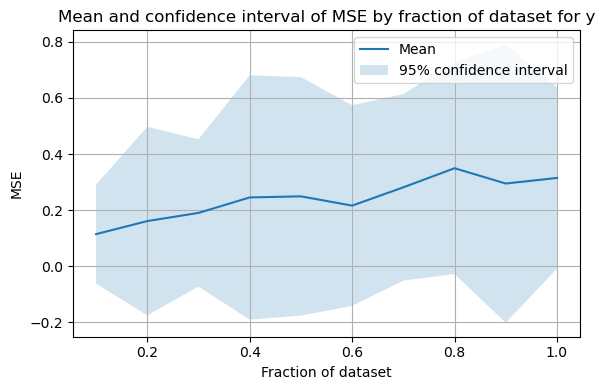

  0%|▍                                                                                 | 1/200 [00:01<04:11,  1.26s/it]

params: [1.20450146 0.74721585 1.5682751  0.83018495]
Minimum and Maximum of sim_data: 0.25197240305591295, 4.865113992592507
MSE: 0.02505074345401485


  1%|▊                                                                                 | 2/200 [00:02<04:36,  1.39s/it]

params: [1.40137652 0.71165934 1.42663071 1.45472905]
Minimum and Maximum of sim_data: 0.14280748690822911, 6.23836095039208
MSE: 0.1111433031750572


  2%|█▏                                                                                | 3/200 [00:04<04:24,  1.34s/it]

params: [1.05373581 0.62587092 1.62977369 0.97317839]
Minimum and Maximum of sim_data: 0.3512200052748286, 3.975007818799706
MSE: 0.005622545273776997


  2%|█▋                                                                                | 4/200 [00:05<04:13,  1.29s/it]

params: [1.02018386 0.54761307 1.58411096 0.90336683]
Minimum and Maximum of sim_data: 0.4369988429663183, 3.94873829654361
MSE: 0.15791033877579205


  2%|██                                                                                | 5/200 [00:06<04:04,  1.26s/it]

params: [1.56246773 0.90796394 1.44729167 1.22373726]
Minimum and Maximum of sim_data: 0.12593376536698775, 6.23836095039208
MSE: 0.09412140596810831


  3%|██▍                                                                               | 6/200 [00:07<04:15,  1.32s/it]

params: [1.19956365 0.76595168 1.48554183 0.93056456]
Minimum and Maximum of sim_data: 0.3455570056710674, 3.977897041226194
MSE: 0.049812414094638845


  4%|██▊                                                                               | 7/200 [00:09<04:28,  1.39s/it]

params: [1.17103112 0.86445226 1.82022818 1.17540083]
Minimum and Maximum of sim_data: 0.09651863497348001, 5.599384080149581
MSE: 0.14732503733837493


  4%|███▎                                                                              | 8/200 [00:10<04:09,  1.30s/it]

params: [1.67053022 0.79179604 1.11826792 0.92473316]
Minimum and Maximum of sim_data: 0.15587283466440227, 5.228009863738059
MSE: 0.09819711231663636


  4%|███▋                                                                              | 9/200 [00:11<04:05,  1.29s/it]

params: [1.77728547 0.94029818 1.02894996 0.70669994]
Minimum and Maximum of sim_data: 0.2877611853037308, 5.095425931710304
MSE: 0.22094641065858486


  5%|████                                                                             | 10/200 [00:12<03:55,  1.24s/it]

params: [0.93345791 0.52406233 1.64702793 0.9077926 ]
Minimum and Maximum of sim_data: 0.47024261270758255, 3.738198346885363
MSE: 0.03757809893094988


  6%|████▍                                                                            | 11/200 [00:14<03:54,  1.24s/it]

params: [1.08571337 0.64327317 1.64304414 0.95689362]
Minimum and Maximum of sim_data: 0.236231084778616, 5.571196469395786
MSE: 0.26243509354460204


  6%|████▊                                                                            | 12/200 [00:15<03:51,  1.23s/it]

params: [1.5364828  0.81290551 0.97156856 0.44682017]
Minimum and Maximum of sim_data: 0.5120657081796061, 4.564769094157125
MSE: 0.5271759567467537


  6%|█████▎                                                                           | 13/200 [00:16<04:07,  1.32s/it]

params: [1.14737539 0.69329207 1.95552735 1.72456334]
Minimum and Maximum of sim_data: 0.10174820289641506, 6.114004609747
MSE: 0.34947847032059265


  7%|█████▋                                                                           | 14/200 [00:18<04:14,  1.37s/it]

params: [1.16208741 0.57200584 1.45089809 0.81996114]
Minimum and Maximum of sim_data: 0.4571346460446707, 4.78163509155479
MSE: 0.04198664654040786


  8%|██████                                                                           | 15/200 [00:19<04:19,  1.40s/it]

params: [1.27063546 0.63149665 1.39023282 0.66356682]
Minimum and Maximum of sim_data: 0.34780871607437286, 6.114004609747
MSE: 0.07165100484910636


  8%|██████▍                                                                          | 16/200 [00:21<04:13,  1.38s/it]

params: [0.82831291 0.39372846 1.95501547 1.02009745]
Minimum and Maximum of sim_data: 0.5704556312151448, 4.78163509155479
MSE: 0.04295192205643304


  8%|██████▉                                                                          | 17/200 [00:22<04:03,  1.33s/it]

params: [1.85639328 0.8923057  0.82481741 0.48092803]
Minimum and Maximum of sim_data: 0.49651583141997474, 4.132586151432476
MSE: 0.5415228319169592


  9%|███████▎                                                                         | 18/200 [00:23<04:05,  1.35s/it]

params: [1.12416404 0.80668992 1.77473238 0.92284887]
Minimum and Maximum of sim_data: 0.14153426361178487, 5.1833847621957005
MSE: 0.2186101323406619


 10%|███████▋                                                                         | 19/200 [00:24<03:48,  1.26s/it]

params: [0.93446443 0.48456801 1.85358605 1.01217584]
Minimum and Maximum of sim_data: 0.3024804371747745, 3.15244126901493
MSE: 0.004441914898286002


 10%|████████                                                                         | 20/200 [00:26<03:41,  1.23s/it]

params: [0.96069227 0.53707959 1.78382266 0.97082671]
Minimum and Maximum of sim_data: 0.3431995577073647, 4.559773495430797
MSE: 0.08436636542500939


 10%|████████▌                                                                        | 21/200 [00:27<03:57,  1.33s/it]

params: [1.83343324 0.89296235 1.04519472 0.755611  ]
Minimum and Maximum of sim_data: 0.16347255010356404, 5.433153687077125
MSE: 0.21141100486722886


 11%|████████▉                                                                        | 22/200 [00:28<04:02,  1.36s/it]

params: [1.53242511 0.92291586 1.26252695 0.75139599]
Minimum and Maximum of sim_data: 0.25619860011992035, 5.154185399153801
MSE: 0.2479434632541934


 12%|█████████▎                                                                       | 23/200 [00:30<04:07,  1.40s/it]

params: [1.81650435 0.77400496 1.01109155 0.61222336]
Minimum and Maximum of sim_data: 0.21304476552086057, 6.1992252801913335
MSE: 0.18197663549709958


 12%|█████████▋                                                                       | 24/200 [00:31<04:11,  1.43s/it]

params: [1.71519271 1.16915394 1.46588254 1.4619716 ]
Minimum and Maximum of sim_data: 0.043880869892755935, 6.3450090734766045
MSE: 0.3743753878595566


 12%|██████████▏                                                                      | 25/200 [00:33<04:09,  1.43s/it]

params: [1.61886915 0.95220376 1.32178753 1.13263919]
Minimum and Maximum of sim_data: 0.12761362176507682, 5.52052404752254
MSE: 0.20316951212684153


 13%|██████████▌                                                                      | 26/200 [00:34<04:05,  1.41s/it]

params: [0.97047725 0.46716359 1.75045466 0.78886437]
Minimum and Maximum of sim_data: 0.38268497724703987, 6.145820381609693
MSE: 0.018457843923641807


 14%|██████████▉                                                                      | 27/200 [00:36<03:57,  1.37s/it]

params: [0.90091825 0.42807364 1.89034732 1.05112608]
Minimum and Maximum of sim_data: 0.3811578262099425, 6.206324899377759
MSE: 0.029728908536742964


 14%|███████████▎                                                                     | 28/200 [00:37<03:56,  1.38s/it]

params: [1.06135586 0.66880069 1.74275063 0.98600105]
Minimum and Maximum of sim_data: 0.22891234933927387, 4.784340210638217
MSE: 0.18146326355681702


 14%|███████████▋                                                                     | 29/200 [00:38<03:59,  1.40s/it]

params: [1.0250144  0.49328086 1.66963203 1.02328397]
Minimum and Maximum of sim_data: 0.4126833242094373, 6.070171321495138
MSE: 0.03034819923068131


 15%|████████████▏                                                                    | 30/200 [00:40<03:56,  1.39s/it]

params: [1.77300097 1.03599554 1.33252805 1.16348695]
Minimum and Maximum of sim_data: 0.07289764480583735, 6.23836095039208
MSE: 0.17768396779422585


 16%|████████████▌                                                                    | 31/200 [00:41<03:51,  1.37s/it]

params: [0.90313203 0.42714139 1.86673846 1.11598819]
Minimum and Maximum of sim_data: 0.3819492941742106, 6.1819525935455495
MSE: 0.021519577910587763


 16%|████████████▉                                                                    | 32/200 [00:43<03:58,  1.42s/it]

params: [1.30864885 0.625146   1.38798108 0.93825239]
Minimum and Maximum of sim_data: 0.31317384354447975, 4.782990818169098
MSE: 0.03177423963183794


 16%|█████████████▎                                                                   | 33/200 [00:44<03:50,  1.38s/it]

params: [0.99476724 0.59630942 1.74357624 0.9578314 ]
Minimum and Maximum of sim_data: 0.31076094819874944, 4.604155252127827
MSE: 0.06612775981602606


 17%|█████████████▊                                                                   | 34/200 [00:45<03:43,  1.35s/it]

params: [1.26354643 0.57391237 1.4008358  0.9874395 ]
Minimum and Maximum of sim_data: 0.21354587188954838, 7.241741829996782
MSE: 0.19455478183735944


 18%|██████████████▏                                                                  | 35/200 [00:47<03:46,  1.37s/it]

params: [1.0732393  0.56888616 1.69644339 0.98905056]
Minimum and Maximum of sim_data: 0.26178613969698894, 6.114004609747
MSE: 0.019082339282676934


 18%|██████████████▌                                                                  | 36/200 [00:48<03:50,  1.41s/it]

params: [0.9485697  0.49105973 1.63717233 0.73305014]
Minimum and Maximum of sim_data: 0.4701125015789366, 5.035533631174219
MSE: 0.209936923422167


 18%|██████████████▉                                                                  | 37/200 [00:49<03:39,  1.34s/it]

params: [1.0324339  0.47160355 1.45081537 0.80180508]
Minimum and Maximum of sim_data: 0.6171767377012435, 5.1849717830352215
MSE: 0.22224263625856663


 19%|███████████████▍                                                                 | 38/200 [00:51<03:37,  1.34s/it]

params: [1.0671347  0.59887224 1.62306359 0.92454326]
Minimum and Maximum of sim_data: 0.35300447104405563, 4.371243777163832
MSE: 0.059453606033656126


 20%|███████████████▊                                                                 | 39/200 [00:52<03:42,  1.38s/it]

params: [1.1136344  0.49745442 1.50256298 0.90754074]
Minimum and Maximum of sim_data: 0.45246678079353403, 6.23836095039208
MSE: 0.1636495713899367


 20%|████████████████▏                                                                | 40/200 [00:54<03:44,  1.40s/it]

params: [1.57926984 0.78794909 1.21691054 0.81786161]
Minimum and Maximum of sim_data: 0.22914051965378304, 5.52052404752254
MSE: 0.1442363726489553


 20%|████████████████▌                                                                | 41/200 [00:55<03:46,  1.42s/it]

params: [1.76194548 1.04295843 1.37036028 1.40051126]
Minimum and Maximum of sim_data: 0.05216027780732096, 6.5999976055268155
MSE: 0.5108660590409145


 21%|█████████████████                                                                | 42/200 [00:56<03:43,  1.41s/it]

params: [1.33080022 0.54318094 1.26134596 0.77687744]
Minimum and Maximum of sim_data: 0.39930143451511774, 6.255288661917237
MSE: 0.330226705503138


 22%|█████████████████▍                                                               | 43/200 [00:58<03:44,  1.43s/it]

params: [1.34316489 0.64600739 1.38494963 0.97593455]
Minimum and Maximum of sim_data: 0.26397938386665315, 6.240313461670725
MSE: 0.047089012104474345


 22%|█████████████████▊                                                               | 44/200 [00:59<03:43,  1.43s/it]

params: [0.94921213 0.47904973 1.8790421  1.1848151 ]
Minimum and Maximum of sim_data: 0.29990314437154525, 6.375350539565269
MSE: 0.0224550452910391


 22%|██████████████████▏                                                              | 45/200 [01:01<03:35,  1.39s/it]

params: [1.19015174 0.69006567 1.46466334 0.71837904]
Minimum and Maximum of sim_data: 0.3604450125536055, 5.203636702141049
MSE: 0.36168558678523294


 23%|██████████████████▋                                                              | 46/200 [01:02<03:36,  1.40s/it]

params: [1.0193475  0.53907279 1.75948447 0.97561278]
Minimum and Maximum of sim_data: 0.2651558440832616, 6.165443235190493
MSE: 0.027804073703865523


 24%|███████████████████                                                              | 47/200 [01:04<03:39,  1.44s/it]

params: [0.86205703 0.49391701 1.92739982 0.97334939]
Minimum and Maximum of sim_data: 0.2883473153609307, 5.228390436960006
MSE: 0.17024871854662207


 24%|███████████████████▍                                                             | 48/200 [01:05<03:38,  1.44s/it]

params: [0.79867254 0.31933843 1.93608734 0.96765047]
Minimum and Maximum of sim_data: 0.7480798532137196, 5.921893087631822
MSE: 0.32366681391608665


 24%|███████████████████▊                                                             | 49/200 [01:06<03:26,  1.37s/it]

params: [0.7910704  0.37194725 1.97415045 1.16189398]
Minimum and Maximum of sim_data: 0.4371023630540551, 5.988571477011609
MSE: 0.15587563921128977


 25%|████████████████████▎                                                            | 50/200 [01:08<03:25,  1.37s/it]

params: [1.13467823 0.59733872 1.6426042  1.01782049]
Minimum and Maximum of sim_data: 0.2681321818293054, 6.23836095039208
MSE: 0.03167996687000855


 26%|████████████████████▋                                                            | 51/200 [01:09<03:33,  1.43s/it]

params: [1.31551435 0.83766498 1.66700832 1.16128333]
Minimum and Maximum of sim_data: 0.11787328445929603, 6.158194467671824
MSE: 0.20602407952390736


 26%|█████████████████████                                                            | 52/200 [01:11<03:35,  1.46s/it]

params: [1.27458577 0.74252639 1.49349436 0.98809645]
Minimum and Maximum of sim_data: 0.23506923575502495, 5.58780955096592
MSE: 0.145993679076092


 26%|█████████████████████▍                                                           | 53/200 [01:12<03:37,  1.48s/it]

params: [1.62812706 1.07884011 1.43945376 1.28114046]
Minimum and Maximum of sim_data: 0.06871360252883807, 6.007624791138375
MSE: 0.2668968202476007


 27%|█████████████████████▊                                                           | 54/200 [01:14<03:37,  1.49s/it]

params: [1.37811752 0.76249643 1.35400753 0.88493682]
Minimum and Maximum of sim_data: 0.2511283397962876, 5.594713277758061
MSE: 0.13219973553343772


 28%|██████████████████████▎                                                          | 55/200 [01:15<03:33,  1.47s/it]

params: [1.03965717 0.66218568 1.85463232 1.06199484]
Minimum and Maximum of sim_data: 0.21792241249498678, 5.184101558485651
MSE: 0.7419554584520281


 28%|██████████████████████▋                                                          | 56/200 [01:17<03:31,  1.47s/it]

params: [0.83382926 0.42104136 1.94713188 1.01898647]
Minimum and Maximum of sim_data: 0.38778864120819273, 5.67978886761019
MSE: 0.06875672306401195


 28%|███████████████████████                                                          | 57/200 [01:18<03:26,  1.45s/it]

params: [1.481743   0.69563436 1.26757066 0.99449732]
Minimum and Maximum of sim_data: 0.19672297175928702, 6.060721165902131
MSE: 0.11464060832744477


 29%|███████████████████████▍                                                         | 58/200 [01:20<03:32,  1.50s/it]

params: [1.17773992 0.62643123 1.70344407 1.33603664]
Minimum and Maximum of sim_data: 0.19954356248128502, 6.7161210788629795
MSE: 0.1176708123245526


 30%|███████████████████████▉                                                         | 59/200 [01:21<03:27,  1.47s/it]

params: [1.2221363  0.98552246 1.81211685 1.18619617]
Minimum and Maximum of sim_data: 0.1084737514715986, 4.873292743106892
MSE: 1.114323926909126


 30%|████████████████████████▎                                                        | 60/200 [01:22<03:24,  1.46s/it]

params: [1.3045616  0.60502469 1.36870231 0.80121374]
Minimum and Maximum of sim_data: 0.34726285441900456, 6.260948818548155
MSE: 0.06075102394465807


 30%|████████████████████████▋                                                        | 61/200 [01:24<03:28,  1.50s/it]

params: [1.46204966 1.26403291 1.91342294 1.71845515]
Minimum and Maximum of sim_data: 0.03053967461431337, 6.171029302296362
MSE: 0.8526150690574388


 31%|█████████████████████████                                                        | 62/200 [01:26<03:24,  1.48s/it]

params: [1.29023532 0.86552676 1.6798506  1.20830645]
Minimum and Maximum of sim_data: 0.13968027849999054, 5.636788561177382
MSE: 0.6090597831530079


 32%|█████████████████████████▌                                                       | 63/200 [01:27<03:22,  1.48s/it]

params: [0.99582701 0.38945078 1.71731013 1.23875614]
Minimum and Maximum of sim_data: 0.46895825992739726, 6.878491411200743
MSE: 0.4962528866129382


 32%|█████████████████████████▉                                                       | 64/200 [01:29<03:23,  1.50s/it]

params: [1.78487328 1.0232783  1.29524858 1.06971321]
Minimum and Maximum of sim_data: 0.07760479964683371, 6.23836095039208
MSE: 0.2875189550268228


 32%|██████████████████████████▎                                                      | 65/200 [01:30<03:20,  1.48s/it]

params: [1.04158192 0.6623548  1.66894652 0.81854034]
Minimum and Maximum of sim_data: 0.22898994011553733, 5.295436931799025
MSE: 0.3227047690284143


 33%|██████████████████████████▋                                                      | 66/200 [01:31<03:14,  1.45s/it]

params: [0.9682933  0.55453712 1.89938378 1.17115429]
Minimum and Maximum of sim_data: 0.21600092104040697, 5.828022515128488
MSE: 0.09300419040735196


 34%|███████████████████████████▏                                                     | 67/200 [01:33<03:14,  1.46s/it]

params: [1.1955663  0.86508129 1.94331143 1.31721746]
Minimum and Maximum of sim_data: 0.07457572350276233, 6.23836095039208
MSE: 0.47476642098293526


 34%|███████████████████████████▌                                                     | 68/200 [01:34<03:17,  1.49s/it]

params: [1.38011003 0.81664804 1.71836796 1.72115344]
Minimum and Maximum of sim_data: 0.08478615450887517, 7.4058104941838785
MSE: 0.324710904270599


 34%|███████████████████████████▉                                                     | 69/200 [01:36<03:06,  1.42s/it]

params: [1.28309133 0.64574794 1.14652123 0.73136771]
Minimum and Maximum of sim_data: 0.482597740711001, 4.388392376948475
MSE: 0.4877023713395749


 35%|████████████████████████████▎                                                    | 70/200 [01:37<03:09,  1.46s/it]

params: [1.37650202 0.66314384 1.41072146 1.17132935]
Minimum and Maximum of sim_data: 0.17788506245207863, 6.8040726683708925
MSE: 0.15942426339764265


 36%|████████████████████████████▊                                                    | 71/200 [01:39<03:09,  1.47s/it]

params: [0.98249938 0.57303483 1.83736356 1.08913077]
Minimum and Maximum of sim_data: 0.2260012432660407, 5.7556086122640915
MSE: 0.1189763628539181


 36%|█████████████████████████████▏                                                   | 72/200 [01:40<03:07,  1.46s/it]

params: [1.14662693 0.49994807 1.33900571 0.6438317 ]
Minimum and Maximum of sim_data: 0.749613740946791, 5.1846271484430755
MSE: 0.32276508697464273


 36%|█████████████████████████████▌                                                   | 73/200 [01:42<03:04,  1.45s/it]

params: [1.51495253 0.97207547 1.30558087 1.07381938]
Minimum and Maximum of sim_data: 0.18745117816509804, 4.631132576947568
MSE: 0.6629763107455744


 37%|█████████████████████████████▉                                                   | 74/200 [01:43<03:01,  1.44s/it]

params: [1.25479409 0.67344595 1.33996008 0.68364214]
Minimum and Maximum of sim_data: 0.4247800147565651, 5.2508542058036936
MSE: 0.1915507416087942


 38%|██████████████████████████████▍                                                  | 75/200 [01:44<02:59,  1.43s/it]

params: [1.47515097 0.77066982 1.17228133 0.64545574]
Minimum and Maximum of sim_data: 0.3306965548058273, 5.414027570722496
MSE: 0.19676184836825567


 38%|██████████████████████████████▊                                                  | 76/200 [01:46<02:58,  1.44s/it]

params: [1.02046664 0.7254515  1.93142167 1.12353198]
Minimum and Maximum of sim_data: 0.11986477351471644, 5.5044861942527925
MSE: 0.47753753421521405


 38%|███████████████████████████████▏                                                 | 77/200 [01:47<02:57,  1.44s/it]

params: [0.87826698 0.4257879  1.75599246 0.83339815]
Minimum and Maximum of sim_data: 0.5213445313171647, 5.269262206764671
MSE: 0.2521192995853093


 39%|███████████████████████████████▌                                                 | 78/200 [01:49<02:58,  1.46s/it]

params: [1.60873982 0.67167899 1.195052   1.10216544]
Minimum and Maximum of sim_data: 0.13953120717884432, 7.095548176470698
MSE: 0.44268245902918474


 40%|███████████████████████████████▉                                                 | 79/200 [01:50<02:55,  1.45s/it]

params: [1.74653622 0.76882826 1.08683987 0.74821386]
Minimum and Maximum of sim_data: 0.18652591360666712, 6.23836095039208
MSE: 0.1594880734955853


 40%|████████████████████████████████▍                                                | 80/200 [01:52<02:54,  1.45s/it]

params: [1.3565607  0.54922629 1.1445303  0.60218908]
Minimum and Maximum of sim_data: 0.6056752607196875, 5.3571922755520385
MSE: 0.5131523623174389


 40%|████████████████████████████████▊                                                | 81/200 [01:53<02:55,  1.47s/it]

params: [1.44915674 0.74578341 1.36246504 1.11274496]
Minimum and Maximum of sim_data: 0.16002523062921234, 6.387586660755921
MSE: 0.05347673744363614


 41%|█████████████████████████████████▏                                               | 82/200 [01:55<02:53,  1.47s/it]

params: [1.03789827 0.52378814 1.79945334 1.29985115]
Minimum and Maximum of sim_data: 0.257474070318406, 6.725256191780223
MSE: 0.07328584316866808


 42%|█████████████████████████████████▌                                               | 83/200 [01:56<02:56,  1.51s/it]

params: [1.74458859 0.8650527  1.15404798 1.021549  ]
Minimum and Maximum of sim_data: 0.10533800015905548, 6.25287823361563
MSE: 0.06923285848382593


 42%|██████████████████████████████████                                               | 84/200 [01:58<03:01,  1.56s/it]

params: [1.75062585 1.07346232 1.33055051 1.23769996]
Minimum and Maximum of sim_data: 0.06203758441031515, 6.146054938977738
MSE: 0.3518811569242534


 42%|██████████████████████████████████▍                                              | 85/200 [01:59<02:51,  1.49s/it]

params: [1.13156155 0.59915471 1.55166423 0.80472671]
Minimum and Maximum of sim_data: 0.3780829499462885, 5.40111312914208
MSE: 0.11205446104785802


 43%|██████████████████████████████████▊                                              | 86/200 [02:01<02:45,  1.45s/it]

params: [1.06404485 0.66938841 1.66116084 0.95685412]
Minimum and Maximum of sim_data: 0.30621954493430165, 4.581765150729928
MSE: 0.34894115380813806


 44%|███████████████████████████████████▏                                             | 87/200 [02:02<02:46,  1.48s/it]

params: [1.2265534  0.57172356 1.41001754 0.7388459 ]
Minimum and Maximum of sim_data: 0.42839674158778646, 6.130967331736477
MSE: 0.055033664016177125


 44%|███████████████████████████████████▋                                             | 88/200 [02:04<02:46,  1.49s/it]

params: [1.2514716  0.72194208 1.59016523 1.19971276]
Minimum and Maximum of sim_data: 0.18812210729685716, 6.2668799911471895
MSE: 0.08464513831664895


 44%|████████████████████████████████████                                             | 89/200 [02:05<02:48,  1.52s/it]

params: [1.46162782 0.63581523 1.35530288 1.17891741]
Minimum and Maximum of sim_data: 0.17301794901115536, 7.116892622788589
MSE: 0.527587252498139


 45%|████████████████████████████████████▍                                            | 90/200 [02:07<02:50,  1.55s/it]

params: [1.85069086 1.37664861 1.24349429 0.82276665]
Minimum and Maximum of sim_data: 0.062455695079211955, 6.7116636311421205
MSE: 0.5321121373792912


 46%|████████████████████████████████████▊                                            | 91/200 [02:08<02:47,  1.54s/it]

params: [1.13817911 0.55315404 1.74013961 1.46507622]
Minimum and Maximum of sim_data: 0.20128334841678572, 7.702719521061687
MSE: 0.2669263563697116


 46%|█████████████████████████████████████▎                                           | 92/200 [02:10<02:45,  1.53s/it]

params: [1.23352814 0.56743368 1.49762535 1.15767527]
Minimum and Maximum of sim_data: 0.26008977527008786, 6.737816171066091
MSE: 0.09835305086721252


 46%|█████████████████████████████████████▋                                           | 93/200 [02:11<02:43,  1.53s/it]

params: [1.80681819 0.96997751 1.0753662  0.74370546]
Minimum and Maximum of sim_data: 0.14422749622667191, 5.399714298663174
MSE: 0.13799557885852068


 47%|██████████████████████████████████████                                           | 94/200 [02:13<02:41,  1.52s/it]

params: [1.04362396 0.5611716  1.59493414 0.79918431]
Minimum and Maximum of sim_data: 0.38501523823643796, 5.23401650444478
MSE: 0.1556695238879236


 48%|██████████████████████████████████████▍                                          | 95/200 [02:15<02:40,  1.53s/it]

params: [1.12349008 0.52904426 1.56565054 1.06276605]
Minimum and Maximum of sim_data: 0.3478934240148286, 6.5144399430157565
MSE: 0.174207463743339


 48%|██████████████████████████████████████▉                                          | 96/200 [02:16<02:38,  1.52s/it]

params: [1.34888081 0.72104971 1.36007594 0.87956853]
Minimum and Maximum of sim_data: 0.27729114296456864, 5.502543147187364
MSE: 0.09397903850616687


 48%|███████████████████████████████████████▎                                         | 97/200 [02:18<02:36,  1.52s/it]

params: [0.92738343 0.44340412 1.94574763 1.28782725]
Minimum and Maximum of sim_data: 0.2907610341187502, 6.916344107450456
MSE: 0.11072555806327275


 49%|███████████████████████████████████████▋                                         | 98/200 [02:19<02:35,  1.53s/it]

params: [1.33660193 0.92126196 1.78547732 1.5565583 ]
Minimum and Maximum of sim_data: 0.0865403719115926, 6.25443159739529
MSE: 0.5401252227974755


 50%|████████████████████████████████████████                                         | 99/200 [02:21<02:31,  1.50s/it]

params: [1.30759717 0.69620498 1.49617629 1.03220945]
Minimum and Maximum of sim_data: 0.22018458135539895, 6.379790014382289
MSE: 0.03786213548898093


 50%|████████████████████████████████████████                                        | 100/200 [02:22<02:25,  1.46s/it]

params: [1.02364571 0.5318074  1.66831178 0.90427295]
Minimum and Maximum of sim_data: 0.3499346954605288, 5.730969370031821
MSE: 0.043693200605057936


 50%|████████████████████████████████████████▍                                       | 101/200 [02:23<02:27,  1.49s/it]

params: [1.04083002 0.45936026 1.75724131 1.28930337]
Minimum and Maximum of sim_data: 0.32674002569206545, 7.401497165542682
MSE: 0.26507976180506637


 51%|████████████████████████████████████████▊                                       | 102/200 [02:25<02:25,  1.49s/it]

params: [0.99538695 0.46089459 1.76696289 1.16662781]
Minimum and Maximum of sim_data: 0.3560544546533542, 6.688994832736052
MSE: 0.07869934091329035


 52%|█████████████████████████████████████████▏                                      | 103/200 [02:26<02:24,  1.49s/it]

params: [1.30812168 0.74320586 1.56196536 1.07858043]
Minimum and Maximum of sim_data: 0.18751389958464262, 6.400861246108031
MSE: 0.09242800575351276


 52%|█████████████████████████████████████████▌                                      | 104/200 [02:28<02:24,  1.50s/it]

params: [1.35631059 0.63891055 1.43492289 1.24214165]
Minimum and Maximum of sim_data: 0.17718918453101373, 6.961290384121099
MSE: 0.13046143910335553


 52%|██████████████████████████████████████████                                      | 105/200 [02:30<02:27,  1.55s/it]

params: [1.68541569 1.18054396 1.61466029 1.84177556]
Minimum and Maximum of sim_data: 0.03008035750985692, 6.9841182367120584
MSE: 0.5348900626042621


 53%|██████████████████████████████████████████▍                                     | 106/200 [02:31<02:23,  1.53s/it]

params: [1.29539153 0.68214707 1.32053261 0.72968612]
Minimum and Maximum of sim_data: 0.39352219849550907, 5.2796460352983186
MSE: 0.1407599417750844


 54%|██████████████████████████████████████████▊                                     | 107/200 [02:33<02:21,  1.52s/it]

params: [0.97479119 0.53063455 1.96189689 1.66956992]
Minimum and Maximum of sim_data: 0.22415464412847372, 6.314066548333259
MSE: 0.13536863846589633


 54%|███████████████████████████████████████████▏                                    | 108/200 [02:34<02:19,  1.51s/it]

params: [1.44791653 0.65674224 1.24747821 0.93611575]
Minimum and Maximum of sim_data: 0.2348822449778081, 6.210955655309729
MSE: 0.09341438171808018


 55%|███████████████████████████████████████████▌                                    | 109/200 [02:36<02:17,  1.51s/it]

params: [0.9205732  0.42739978 1.71791722 1.073309  ]
Minimum and Maximum of sim_data: 0.432571378624748, 6.14539230493508
MSE: 0.5320335815413497


 55%|████████████████████████████████████████████                                    | 110/200 [02:37<02:14,  1.49s/it]

params: [1.53949339 0.69121535 1.18821615 0.92375888]
Minimum and Maximum of sim_data: 0.20493087191471326, 6.211928670104009
MSE: 0.08741798974846114


 56%|████████████████████████████████████████████▍                                   | 111/200 [02:39<02:15,  1.52s/it]

params: [1.16227345 0.68786468 1.71554811 1.2534916 ]
Minimum and Maximum of sim_data: 0.16731330941546174, 6.29589711068693
MSE: 0.1313904609622104


 56%|████████████████████████████████████████████▊                                   | 112/200 [02:40<02:14,  1.53s/it]

params: [1.95119606 0.85890561 0.87129643 0.47360817]
Minimum and Maximum of sim_data: 0.30729926281380215, 5.669270564819362
MSE: 0.4233097627311922


 56%|█████████████████████████████████████████████▏                                  | 113/200 [02:42<02:14,  1.54s/it]

params: [1.13707831 0.90332473 1.86217787 1.10830207]
Minimum and Maximum of sim_data: 0.08027216065479549, 5.488973270263045
MSE: 0.765001391603068


 57%|█████████████████████████████████████████████▌                                  | 114/200 [02:43<02:12,  1.54s/it]

params: [1.74477708 0.84390723 1.18478424 0.86474661]
Minimum and Maximum of sim_data: 0.13527669151989005, 6.370890307614383
MSE: 0.29398416695573


 57%|██████████████████████████████████████████████                                  | 115/200 [02:45<02:07,  1.50s/it]

params: [1.34245076 0.56226687 1.25986227 0.76922834]
Minimum and Maximum of sim_data: 0.37658695750018184, 6.248716040212679
MSE: 0.2703812228035372


 58%|██████████████████████████████████████████████▍                                 | 116/200 [02:46<02:04,  1.48s/it]

params: [0.99397897 0.4490513  1.74286448 1.14683547]
Minimum and Maximum of sim_data: 0.40651003465946506, 6.544393288432471
MSE: 0.12687580942162852


 58%|██████████████████████████████████████████████▊                                 | 117/200 [02:48<02:04,  1.50s/it]

params: [1.27659584 0.86804916 1.8191236  1.3625948 ]
Minimum and Maximum of sim_data: 0.08260964447358392, 6.453352459745524
MSE: 0.5038732595757821


 59%|███████████████████████████████████████████████▏                                | 118/200 [02:49<02:01,  1.48s/it]

params: [0.79153905 0.3822917  1.92592887 0.89576351]
Minimum and Maximum of sim_data: 0.5185770897524119, 5.300622389115488
MSE: 0.32369873710659003


 60%|███████████████████████████████████████████████▌                                | 119/200 [02:51<01:58,  1.46s/it]

params: [1.68991097 0.81659943 1.11262301 0.79575011]
Minimum and Maximum of sim_data: 0.19809752922364965, 5.52052404752254
MSE: 0.21141201411059468


 60%|████████████████████████████████████████████████                                | 120/200 [02:52<01:56,  1.46s/it]

params: [1.15819825 0.78210997 1.90553433 1.51762415]
Minimum and Maximum of sim_data: 0.08315147826948091, 6.538800251420677
MSE: 0.3127576310337564


 60%|████████████████████████████████████████████████▍                               | 121/200 [02:54<01:56,  1.48s/it]

params: [1.56072919 0.86717411 1.22752154 0.78759172]
Minimum and Maximum of sim_data: 0.2085770519357956, 5.391054956696605
MSE: 0.2517027296238738


 61%|████████████████████████████████████████████████▊                               | 122/200 [02:55<01:56,  1.50s/it]

params: [1.27618695 0.93239101 1.90705672 1.41491332]
Minimum and Maximum of sim_data: 0.059542234670988715, 6.443849512362598
MSE: 0.6414205692070545


 62%|█████████████████████████████████████████████████▏                              | 123/200 [02:57<01:56,  1.52s/it]

params: [1.42402587 1.04631883 1.53815219 1.02804915]
Minimum and Maximum of sim_data: 0.10921807160826853, 5.710795744930757
MSE: 0.5608309228481737


 62%|█████████████████████████████████████████████████▌                              | 124/200 [02:58<01:55,  1.52s/it]

params: [1.22956711 0.78692473 1.69454973 1.29826901]
Minimum and Maximum of sim_data: 0.1250526479064231, 6.2321520935958565
MSE: 0.2121472215145946


 62%|██████████████████████████████████████████████████                              | 125/200 [03:00<01:52,  1.49s/it]

params: [0.767004   0.34553052 1.92184502 0.81643391]
Minimum and Maximum of sim_data: 0.6958903857858477, 5.110332812532806
MSE: 0.38872751347655576


 63%|██████████████████████████████████████████████████▍                             | 126/200 [03:01<01:51,  1.51s/it]

params: [1.61546131 0.89587912 1.3657365  1.12707389]
Minimum and Maximum of sim_data: 0.09843031762206018, 6.570448764338191
MSE: 0.14146449876491035


 64%|██████████████████████████████████████████████████▊                             | 127/200 [03:03<01:51,  1.52s/it]

params: [1.42936393 0.88139898 1.49778951 1.18038901]
Minimum and Maximum of sim_data: 0.13494192338119906, 6.0077873837849625
MSE: 0.31108124205242454


 64%|███████████████████████████████████████████████████▏                            | 128/200 [03:04<01:50,  1.54s/it]

params: [0.97147593 0.49932462 1.95084488 1.3546393 ]
Minimum and Maximum of sim_data: 0.22181423387120566, 6.9081594441310346
MSE: 0.14462794375701238


 64%|███████████████████████████████████████████████████▌                            | 129/200 [03:06<01:49,  1.55s/it]

params: [1.49772106 0.72673153 1.37290844 1.32547255]
Minimum and Maximum of sim_data: 0.1065576986821762, 7.204435437838287
MSE: 0.25410607123769763


 65%|████████████████████████████████████████████████████                            | 130/200 [03:07<01:47,  1.54s/it]

params: [1.11751703 0.7406933  1.88547748 1.16976332]
Minimum and Maximum of sim_data: 0.10435779489350198, 6.287986064000322
MSE: 0.303136184570981


 66%|████████████████████████████████████████████████████▍                           | 131/200 [03:09<01:46,  1.55s/it]

params: [1.42597131 0.74779467 1.40565542 1.16757101]
Minimum and Maximum of sim_data: 0.15252829864184092, 6.483336626754783
MSE: 0.061535701589619726


 66%|████████████████████████████████████████████████████▊                           | 132/200 [03:10<01:45,  1.55s/it]

params: [1.66854518 0.85911472 1.38438665 1.53179793]
Minimum and Maximum of sim_data: 0.05721596833910131, 7.296304771897802
MSE: 0.1975189256968636


 66%|█████████████████████████████████████████████████████▏                          | 133/200 [03:12<01:44,  1.56s/it]

params: [1.43931736 0.93621469 1.51034247 1.23187903]
Minimum and Maximum of sim_data: 0.11025753043296371, 6.062954499769477
MSE: 0.30529678905447916


 67%|█████████████████████████████████████████████████████▌                          | 134/200 [03:14<01:41,  1.54s/it]

params: [1.49139665 0.65204026 1.15431505 0.7893744 ]
Minimum and Maximum of sim_data: 0.297028708255394, 5.834034293780129
MSE: 0.19486798581668757


 68%|██████████████████████████████████████████████████████                          | 135/200 [03:15<01:40,  1.54s/it]

params: [1.14143165 0.57025076 1.49973423 0.94494099]
Minimum and Maximum of sim_data: 0.3737235120264341, 5.874093605163013
MSE: 0.13282821493345753


 68%|██████████████████████████████████████████████████████▍                         | 136/200 [03:17<01:38,  1.53s/it]

params: [1.17796209 0.7770697  1.75981482 1.2716419 ]
Minimum and Maximum of sim_data: 0.12014255488220188, 6.05716629182541
MSE: 0.3027818524762677


 68%|██████████████████████████████████████████████████████▊                         | 137/200 [03:18<01:37,  1.55s/it]

params: [1.48730714 0.82601096 1.42246425 1.07229897]
Minimum and Maximum of sim_data: 0.13663905938818827, 6.463979522454337
MSE: 0.10026589690151962


 69%|███████████████████████████████████████████████████████▏                        | 138/200 [03:20<01:34,  1.53s/it]

params: [1.72332322 0.83577683 1.08661761 0.81249751]
Minimum and Maximum of sim_data: 0.1669655027163105, 5.726725995500772
MSE: 0.09409503747316268


 70%|███████████████████████████████████████████████████████▌                        | 139/200 [03:21<01:33,  1.53s/it]

params: [1.81377811 1.12225681 1.36726179 1.15052915]
Minimum and Maximum of sim_data: 0.05282119471071672, 6.487223533624582
MSE: 0.22060326165386598


 70%|████████████████████████████████████████████████████████                        | 140/200 [03:23<01:31,  1.53s/it]

params: [1.23037836 0.67859769 1.59988486 1.19270483]
Minimum and Maximum of sim_data: 0.21616316465233915, 6.2956705986200925
MSE: 0.09966163109984763


 70%|████████████████████████████████████████████████████████▍                       | 141/200 [03:24<01:29,  1.52s/it]

params: [1.95242665 1.2375268  1.22249194 1.03326043]
Minimum and Maximum of sim_data: 0.06169608794055609, 5.52052404752254
MSE: 0.4583145456106218


 71%|████████████████████████████████████████████████████████▊                       | 142/200 [03:26<01:28,  1.52s/it]

params: [1.504961   0.81870602 1.40799756 1.26778815]
Minimum and Maximum of sim_data: 0.1092735181765166, 6.632431330404793
MSE: 0.07257551508283253


 72%|█████████████████████████████████████████████████████████▏                      | 143/200 [03:27<01:26,  1.51s/it]

params: [1.65713142 0.68149086 0.94715472 0.47215263]
Minimum and Maximum of sim_data: 0.5219846521424469, 5.0802826864835176
MSE: 0.5919926880655775


 72%|█████████████████████████████████████████████████████████▌                      | 144/200 [03:29<01:25,  1.53s/it]

params: [1.16673483 0.68480062 1.81525926 1.48605549]
Minimum and Maximum of sim_data: 0.12732651817576565, 6.936231565703501
MSE: 0.23724559373443094


 72%|██████████████████████████████████████████████████████████                      | 145/200 [03:30<01:24,  1.55s/it]

params: [1.3541714  0.89268651 1.89327427 1.99732043]
Minimum and Maximum of sim_data: 0.049646906916988476, 7.698370894628561
MSE: 0.5759948046931679


 73%|██████████████████████████████████████████████████████████▍                     | 146/200 [03:32<01:23,  1.55s/it]

params: [1.83015293 0.76425191 1.01800533 0.8699522 ]
Minimum and Maximum of sim_data: 0.14880937535511818, 6.29066966647723
MSE: 0.27386115560602203


 74%|██████████████████████████████████████████████████████████▊                     | 147/200 [03:34<01:22,  1.56s/it]

params: [1.13768454 0.6617586  1.90394164 1.64616037]
Minimum and Maximum of sim_data: 0.10440368630538827, 7.378128335403506
MSE: 0.23397316830227388


 74%|███████████████████████████████████████████████████████████▏                    | 148/200 [03:35<01:19,  1.53s/it]

params: [1.6570425  0.71096021 1.10972589 0.75730397]
Minimum and Maximum of sim_data: 0.22343132594074952, 6.23836095039208
MSE: 0.23390538163647617


 74%|███████████████████████████████████████████████████████████▌                    | 149/200 [03:37<01:18,  1.53s/it]

params: [1.24371707 0.96126349 1.75254053 1.15085033]
Minimum and Maximum of sim_data: 0.08254158520754723, 5.511647431222772
MSE: 0.558866079246606


 75%|████████████████████████████████████████████████████████████                    | 150/200 [03:38<01:16,  1.53s/it]

params: [1.16795418 0.55155084 1.57078224 1.12605507]
Minimum and Maximum of sim_data: 0.3070543100225286, 6.621155958795418
MSE: 0.08682673390395203


 76%|████████████████████████████████████████████████████████████▍                   | 151/200 [03:40<01:15,  1.54s/it]

params: [1.61386719 0.91524208 1.33181499 1.15593407]
Minimum and Maximum of sim_data: 0.10000608822836848, 6.136885178779668
MSE: 0.17869354570785437


 76%|████████████████████████████████████████████████████████████▊                   | 152/200 [03:41<01:14,  1.55s/it]

params: [1.62787199 0.7624538  1.20207795 0.86251097]
Minimum and Maximum of sim_data: 0.1714756835294787, 6.399610642537088
MSE: 0.1227296910819889


 76%|█████████████████████████████████████████████████████████████▏                  | 153/200 [03:43<01:12,  1.54s/it]

params: [1.32215065 0.70397064 1.42263759 1.01421948]
Minimum and Maximum of sim_data: 0.23353752805361622, 5.999141771831361
MSE: 0.0419635295531167


 77%|█████████████████████████████████████████████████████████████▌                  | 154/200 [03:44<01:10,  1.53s/it]

params: [1.07607496 0.4958876  1.5032433  0.84006894]
Minimum and Maximum of sim_data: 0.5341918309945279, 5.653456699663208
MSE: 0.1542996697887636


 78%|██████████████████████████████████████████████████████████████                  | 155/200 [03:46<01:08,  1.51s/it]

params: [1.16251817 0.57917537 1.43981099 0.80250609]
Minimum and Maximum of sim_data: 0.44998500802358377, 5.457447800964746
MSE: 0.10405866399855226


 78%|██████████████████████████████████████████████████████████████▍                 | 156/200 [03:47<01:06,  1.51s/it]

params: [1.68869583 0.72328464 1.02340237 0.69798705]
Minimum and Maximum of sim_data: 0.2658169297250839, 5.649601763344637
MSE: 0.2887945955927457


 78%|██████████████████████████████████████████████████████████████▊                 | 157/200 [03:49<01:04,  1.50s/it]

params: [1.79944342 0.74458207 1.03666122 0.72643681]
Minimum and Maximum of sim_data: 0.18976447679572678, 6.354040790629868
MSE: 0.30726088008971575


 79%|███████████████████████████████████████████████████████████████▏                | 158/200 [03:50<01:02,  1.49s/it]

params: [1.04602074 0.51744841 1.58136704 0.87203784]
Minimum and Maximum of sim_data: 0.43898198254078885, 5.559905681544709
MSE: 0.08075442384232796


 80%|███████████████████████████████████████████████████████████████▌                | 159/200 [03:52<01:02,  1.52s/it]

params: [0.90782385 0.43441755 1.83408168 1.02120904]
Minimum and Maximum of sim_data: 0.42595731321438063, 5.916667379582337
MSE: 0.054462413579379546


 80%|████████████████████████████████████████████████████████████████                | 160/200 [03:53<01:00,  1.52s/it]

params: [1.9599852  0.78096026 0.95097827 0.68765448]
Minimum and Maximum of sim_data: 0.17624100402889453, 6.23836095039208
MSE: 0.44771855215597184


 80%|████████████████████████████████████████████████████████████████▍               | 161/200 [03:55<01:00,  1.54s/it]

params: [1.83538162 1.05643803 1.3348036  1.49579769]
Minimum and Maximum of sim_data: 0.0381807229821986, 6.887182450202324
MSE: 0.1911360685252252


 81%|████████████████████████████████████████████████████████████████▊               | 162/200 [03:56<00:59,  1.55s/it]

params: [1.38173549 0.9035526  1.49716482 1.07805321]
Minimum and Maximum of sim_data: 0.14949095285236205, 5.719323331886006
MSE: 0.30042745417638417


 82%|█████████████████████████████████████████████████████████████████▏              | 163/200 [03:58<00:57,  1.55s/it]

params: [1.81536836 1.02668023 1.28050695 1.13061874]
Minimum and Maximum of sim_data: 0.07139184340433402, 6.242477400470082
MSE: 0.21422983018480418


 82%|█████████████████████████████████████████████████████████████████▌              | 164/200 [03:59<00:55,  1.53s/it]

params: [1.66156529 0.76438416 1.03221839 0.62894935]
Minimum and Maximum of sim_data: 0.29475474015900915, 5.320343708314658
MSE: 0.2407823300761603


 82%|██████████████████████████████████████████████████████████████████              | 165/200 [04:01<00:53,  1.53s/it]

params: [1.64149387 0.87743079 1.15963958 0.80912012]
Minimum and Maximum of sim_data: 0.17184263371184383, 5.540627210344415
MSE: 0.12109096063631254


 83%|██████████████████████████████████████████████████████████████████▍             | 166/200 [04:03<00:52,  1.56s/it]

params: [1.38478273 0.9510727  1.61204858 1.26131318]
Minimum and Maximum of sim_data: 0.10652511742926031, 5.96154647772843
MSE: 0.42229130374801155


 84%|██████████████████████████████████████████████████████████████████▊             | 167/200 [04:04<00:51,  1.57s/it]

params: [1.57248238 0.76409712 1.2847243  1.17179977]
Minimum and Maximum of sim_data: 0.11780849024599264, 6.740090080654468
MSE: 0.08695472945877572


 84%|███████████████████████████████████████████████████████████████████▏            | 168/200 [04:06<00:49,  1.55s/it]

params: [1.39042935 0.62788215 1.28472041 0.97000626]
Minimum and Maximum of sim_data: 0.24174563526957715, 6.347121264843561
MSE: 0.17722466011216978


 84%|███████████████████████████████████████████████████████████████████▌            | 169/200 [04:07<00:48,  1.56s/it]

params: [1.37281022 0.79378584 1.52953665 1.27584152]
Minimum and Maximum of sim_data: 0.13855665111272739, 6.459293156811229
MSE: 0.12867867782268513


 85%|████████████████████████████████████████████████████████████████████            | 170/200 [04:09<00:46,  1.56s/it]

params: [0.96476339 0.48291257 1.72936898 0.99273729]
Minimum and Maximum of sim_data: 0.37743799957209934, 5.853654532530406
MSE: 0.0673282251784047


 86%|████████████████████████████████████████████████████████████████████▍           | 171/200 [04:10<00:45,  1.57s/it]

params: [1.25499231 0.98822484 1.77238639 1.20041814]
Minimum and Maximum of sim_data: 0.07314812247803056, 5.568610440869715
MSE: 0.7160332728568041


 86%|████████████████████████████████████████████████████████████████████▊           | 172/200 [04:12<00:43,  1.56s/it]

params: [1.03795307 0.47646648 1.60232659 0.89894127]
Minimum and Maximum of sim_data: 0.5198369221101985, 5.758477157854103
MSE: 0.1840745637924319


 86%|█████████████████████████████████████████████████████████████████████▏          | 173/200 [04:14<00:41,  1.55s/it]

params: [1.94640118 0.94312897 1.01227616 0.82593824]
Minimum and Maximum of sim_data: 0.1118604635083869, 5.782077829750802
MSE: 0.11683341665214102


 87%|█████████████████████████████████████████████████████████████████████▌          | 174/200 [04:15<00:40,  1.55s/it]

params: [1.88120417 0.95332566 1.11359217 1.02662587]
Minimum and Maximum of sim_data: 0.08022315008241244, 6.185000222282407
MSE: 0.07676092328284863


 88%|██████████████████████████████████████████████████████████████████████          | 175/200 [04:17<00:38,  1.55s/it]

params: [1.529638   0.87399973 1.41355759 1.27243664]
Minimum and Maximum of sim_data: 0.09825101048698323, 6.493050955634929
MSE: 0.11739276374876738


 88%|██████████████████████████████████████████████████████████████████████▍         | 176/200 [04:18<00:36,  1.53s/it]

params: [1.00683706 0.49752275 1.77658391 1.18086209]
Minimum and Maximum of sim_data: 0.29904121741591705, 6.540536557986079
MSE: 0.032443353350460065


 88%|██████████████████████████████████████████████████████████████████████▊         | 177/200 [04:20<00:35,  1.53s/it]

params: [1.7245931  0.99593782 1.17692774 0.85013655]
Minimum and Maximum of sim_data: 0.12439003917042996, 5.507581175520765
MSE: 0.17191245885616716


 89%|███████████████████████████████████████████████████████████████████████▏        | 178/200 [04:21<00:34,  1.55s/it]

params: [1.15713308 0.67712859 1.61463215 1.09754056]
Minimum and Maximum of sim_data: 0.20532062047701244, 5.924083581203262
MSE: 0.2164531343877946


 90%|███████████████████████████████████████████████████████████████████████▌        | 179/200 [04:23<00:31,  1.51s/it]

params: [1.04239316 0.41518487 1.43175481 0.69668464]
Minimum and Maximum of sim_data: 0.8798247691903115, 5.363460182837148
MSE: 0.6041456510865078


 90%|████████████████████████████████████████████████████████████████████████        | 180/200 [04:24<00:30,  1.54s/it]

params: [1.3584073  0.81167146 1.49971914 1.13196107]
Minimum and Maximum of sim_data: 0.16777283216811842, 6.018612029344053
MSE: 0.1479415166222334


 90%|████████████████████████████████████████████████████████████████████████▍       | 181/200 [04:26<00:29,  1.57s/it]

params: [1.41249826 0.78985204 1.28447452 0.74297753]
Minimum and Maximum of sim_data: 0.29054094335670305, 5.315987335469383
MSE: 0.1925868184187523


 91%|████████████████████████████████████████████████████████████████████████▊       | 182/200 [04:27<00:28,  1.56s/it]

params: [1.15375176 0.6413081  1.71506238 1.28663854]
Minimum and Maximum of sim_data: 0.1899114494375968, 6.566776890947466
MSE: 0.10723666104636015


 92%|█████████████████████████████████████████████████████████████████████████▏      | 183/200 [04:29<00:26,  1.53s/it]

params: [1.53307141 0.74421297 1.1354367  0.70027607]
Minimum and Maximum of sim_data: 0.2929171510238169, 5.409121329991728
MSE: 0.15262494100236748


 92%|█████████████████████████████████████████████████████████████████████████▌      | 184/200 [04:31<00:24,  1.55s/it]

params: [1.64442083 1.23480257 1.49196723 1.2522161 ]
Minimum and Maximum of sim_data: 0.058782943570552276, 5.7647383492583
MSE: 0.6066534707832932


 92%|██████████████████████████████████████████████████████████████████████████      | 185/200 [04:32<00:23,  1.59s/it]

params: [1.75967138 0.89724591 1.32897523 1.51349471]
Minimum and Maximum of sim_data: 0.04906482969061284, 7.44828769219654
MSE: 0.22343480268761393


 93%|██████████████████████████████████████████████████████████████████████████▍     | 186/200 [04:34<00:23,  1.66s/it]

params: [1.76697448 1.04204541 1.24331874 1.06937878]
Minimum and Maximum of sim_data: 0.07841924677136929, 5.897526774792556
MSE: 0.18757218500960968


 94%|██████████████████████████████████████████████████████████████████████████▊     | 187/200 [04:36<00:21,  1.62s/it]

params: [1.17589913 0.67721617 1.62898403 1.10252947]
Minimum and Maximum of sim_data: 0.21728938906748002, 5.962645154041317
MSE: 0.1358782778413889


 94%|███████████████████████████████████████████████████████████████████████████▏    | 188/200 [04:37<00:19,  1.62s/it]

params: [0.95237043 0.56691921 1.97612129 1.26499828]
Minimum and Maximum of sim_data: 0.17259798961371906, 6.178492778284099
MSE: 0.11574842266521776


 94%|███████████████████████████████████████████████████████████████████████████▌    | 189/200 [04:39<00:17,  1.57s/it]

params: [1.9295696  0.77848142 0.82212669 0.42240111]
Minimum and Maximum of sim_data: 0.41773133215300734, 5.398350411652334
MSE: 0.7216403982977495


 95%|████████████████████████████████████████████████████████████████████████████    | 190/200 [04:40<00:15,  1.57s/it]

params: [1.02074469 0.44308941 1.71789944 1.14509591]
Minimum and Maximum of sim_data: 0.42150126444623026, 6.841920951033182
MSE: 0.21117649800583202


 96%|████████████████████████████████████████████████████████████████████████████▍   | 191/200 [04:42<00:14,  1.59s/it]

params: [1.30245013 0.79984159 1.64574679 1.33184817]
Minimum and Maximum of sim_data: 0.13634798690951028, 6.371354625780562
MSE: 0.2594218651878688


 96%|████████████████████████████████████████████████████████████████████████████▊   | 192/200 [04:43<00:12,  1.58s/it]

params: [1.35785774 0.77803638 1.37568462 0.88973401]
Minimum and Maximum of sim_data: 0.2420453829296858, 5.552306684255737
MSE: 0.1355441416425438


 96%|█████████████████████████████████████████████████████████████████████████████▏  | 193/200 [04:45<00:10,  1.54s/it]

params: [1.40148729 0.66961724 1.16441725 0.61539307]
Minimum and Maximum of sim_data: 0.4451243331791073, 5.176328555501301
MSE: 0.2604038240078591


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 194/200 [04:46<00:09,  1.53s/it]

params: [1.27881368 0.56193788 1.45540636 1.15730868]
Minimum and Maximum of sim_data: 0.23986787302239895, 7.041337313243052
MSE: 0.2112997580370188


 98%|██████████████████████████████████████████████████████████████████████████████  | 195/200 [04:48<00:07,  1.52s/it]

params: [1.21342148 0.54142218 1.39616524 0.86995828]
Minimum and Maximum of sim_data: 0.4325605269937659, 5.909406002171065
MSE: 0.14949791267764415


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 196/200 [04:49<00:06,  1.52s/it]

params: [1.42621964 0.65088918 1.24783409 0.85814911]
Minimum and Maximum of sim_data: 0.2903374892312373, 5.9251990731071205
MSE: 0.15860563111315776


 98%|██████████████████████████████████████████████████████████████████████████████▊ | 197/200 [04:51<00:04,  1.53s/it]

params: [1.57700194 0.76010409 1.0663465  0.58435192]
Minimum and Maximum of sim_data: 0.34758309907012164, 5.329317959233734
MSE: 0.258736218199595


 99%|███████████████████████████████████████████████████████████████████████████████▏| 198/200 [04:52<00:03,  1.54s/it]

params: [0.89068356 0.57909246 1.98171892 1.00665467]
Minimum and Maximum of sim_data: 0.18990679068266364, 5.317437017479928
MSE: 0.3315929073843543


100%|███████████████████████████████████████████████████████████████████████████████▌| 199/200 [04:54<00:01,  1.57s/it]

params: [1.09383592 0.49193111 1.51225981 0.93366002]
Minimum and Maximum of sim_data: 0.47215313710807855, 6.060603818546943
MSE: 0.17822969817068032


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [04:56<00:00,  1.48s/it]

params: [1.05843076 0.41824845 1.40302068 0.66832683]
Minimum and Maximum of sim_data: 0.9120141157300055, 5.2880578902790365
MSE: 0.6403542340887013


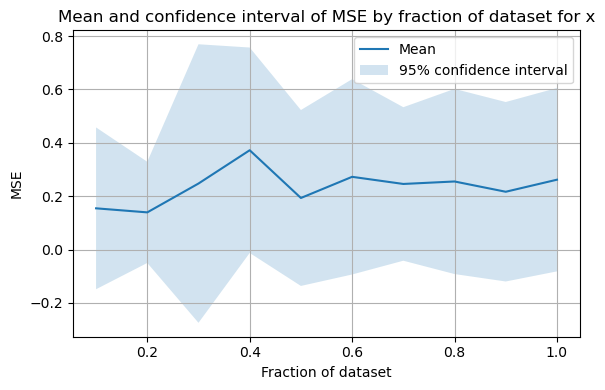

In [14]:
for data_variable in ['y', 'x']:
    try:
        experiment_df = batch_comparison_by_frac(fracs=fracs, data_variable=data_variable,
                                             n_samples=20, bounds=bounds, maxiter=MAX_ITER_SA,
                                             data=data)
    except Exception as e:
        print(f"An error occurred: {e}")

    plt.figure(figsize=(6, 4), layout='tight')
    plt.plot(experiment_df['frac'], experiment_df['mean'], label='Mean')
    plt.fill_between(experiment_df['frac'],
                     experiment_df['conf_int'].apply(lambda x: x[0]),
                     experiment_df['conf_int'].apply(lambda x: x[1]),
                     alpha=0.2, label='95% confidence interval')
    plt.title(f'Mean and confidence interval of MSE by fraction of dataset for {data_variable}')
    plt.xlabel('Fraction of dataset')
    plt.ylabel('MSE')
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.show()

#### How many data-points from each time-series you could remove until you are not able to reverse-engineer the parameters any more?

First, try to ﬁnd the importance of each time-series on reverse-engineering process by ﬁxing one time-series and removing data-points from the other one. In this way, you will ﬁnd the critical number of data-points for each time-series.

Then, if you combine two reduced time-series, could you still infer the parameters?

Does removing every data-point have the same effect on reverse-engineering process? In other words, what are the points that you could remove safely without affecting the inferance procedure? and what are those with critical effects on the process?

In [15]:
def leave_one_out_analysis(data, initial_guess, bounds, maxiter):
    importance_scores = []

    for i in range(len(data)):
        # Exclude one data point
        reduced_data = data.drop(index=i)
        t_reduced, x_reduced, y_reduced = reduced_data['t'].to_numpy(), reduced_data['x'].to_numpy(), reduced_data['y'].to_numpy()

        def mse_objective_reduced(params):
            initial_conditions = [y_reduced[0], x_reduced[0]]
            simulated = solve_lv(params, initial_conditions, t_reduced)
            mse = np.mean((simulated - reduced_data[['y', 'x']].values) ** 2)
            return mse

        # Fit the model on the reduced dataset
        result = dual_annealing(mse_objective_reduced, bounds=bounds, maxiter=maxiter)
        params = result.x
        mse = mse_objective_reduced(params)
        importance_scores.append((i, mse))

    return importance_scores

importance_scores = leave_one_out_analysis(data, initial_guess, bounds, MAX_ITER_SA)

# Sort the scores to see which data points had the most impact
importance_scores.sort(key=lambda x: x[1], reverse=True)
importance_df = pd.DataFrame(importance_scores, columns=['Data Point', 'MSE'])

# Sort the DataFrame by 'MSE' in descending order
importance_df = importance_df.sort_values(by='MSE', ascending=False)
importance_df.head(20)

C:\conda\lib\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\conda\lib\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\conda\lib\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\conda\lib\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\conda\lib\site-packages\scipy\integrate\_odepack_

C:\conda\lib\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\iChin\AppData\Local\Temp\ipykernel_39508\4045571642.py:12: RuntimeWarning: overflow encountered in square
  mse = np.mean((simulated - reduced_data[['y', 'x']].values) ** 2)
C:\Users\iChin\AppData\Local\Temp\ipykernel_39508\4045571642.py:12: RuntimeWarning: overflow encountered in square
  mse = np.mean((simulated - reduced_data[['y', 'x']].values) ** 2)
C:\conda\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\iChin\AppData\Local\Temp\ipykernel_39508\4045571642.py:12: RuntimeWarning: overflow encountered in square
  mse = np.mean((simulated - reduced_data[['y', 'x']].values) ** 2)
C:\conda\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid

C:\conda\lib\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\iChin\AppData\Local\Temp\ipykernel_39508\4045571642.py:12: RuntimeWarning: overflow encountered in square
  mse = np.mean((simulated - reduced_data[['y', 'x']].values) ** 2)
C:\Users\iChin\AppData\Local\Temp\ipykernel_39508\4045571642.py:12: RuntimeWarning: overflow encountered in square
  mse = np.mean((simulated - reduced_data[['y', 'x']].values) ** 2)
C:\conda\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\iChin\AppData\Local\Temp\ipykernel_39508\4045571642.py:12: RuntimeWarning: overflow encountered in square
  mse = np.mean((simulated - reduced_data[['y', 'x']].values) ** 2)
C:\conda\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid

C:\conda\lib\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\conda\lib\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\conda\lib\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\iChin\AppData\Local\Temp\ipykernel_39508\503435265.py:7: RuntimeWarning: overflow encountered in scalar multiply
  dzdt = delta*x*z - gamma*z
C:\Users\iChin\AppData\Local\Temp\ipykernel_39508\503435265.py:6: RuntimeWarning: invalid value encountered in scalar multiply
  dxdt = al

C:\conda\lib\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\conda\lib\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\conda\lib\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\conda\lib\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\conda\lib\site-packages\scipy\integrate\_odepack_

C:\conda\lib\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\iChin\AppData\Local\Temp\ipykernel_39508\4045571642.py:12: RuntimeWarning: overflow encountered in square
  mse = np.mean((simulated - reduced_data[['y', 'x']].values) ** 2)
C:\conda\lib\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\iChin\AppData\Local\Temp\ipykernel_39508\4045571642.py:12: RuntimeWarning: overflow encountered in square
  mse = np.mean((simulated - reduced_data[['y', 'x']].values) ** 2)
C:\conda\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\conda\lib\site-packages\s

C:\conda\lib\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\conda\lib\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\conda\lib\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\conda\lib\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\conda\lib\site-packages\scipy\integrate\_odepack_

C:\conda\lib\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\conda\lib\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\conda\lib\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\conda\lib\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\conda\lib\site-packages\scipy\integrate\_odepack_

,Data Point,MSE
0,99,0.010075
1,65,0.010006
2,21,0.009755
3,93,0.009752
4,28,0.009738
5,72,0.009727
6,56,0.009724
7,45,0.009723
8,73,0.009723
9,96,0.009723


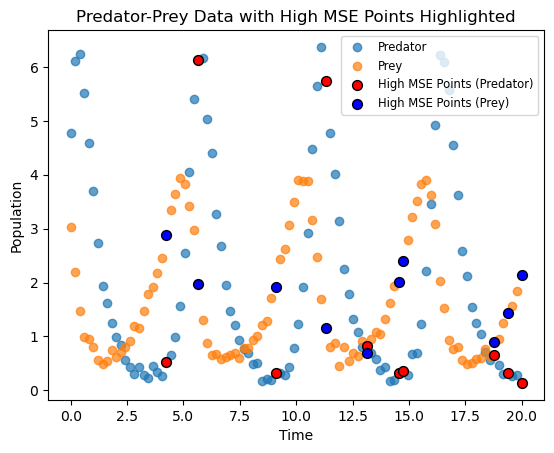

In [27]:
n_highlight = 10  

high_mse_indices = importance_df.head(n_highlight)['Data Point']

# Plot the original data
plt.scatter(data['t'], data['x'], label='Predator', alpha=0.7)
plt.scatter(data['t'], data['y'], label='Prey', alpha=0.7)

# Highlight the points with highest MSE
for idx in high_mse_indices:
    plt.scatter(data.loc[idx, 't'], data.loc[idx, 'x'], color='red', edgecolor='black', s=50, label='High MSE Points (Predator)' if idx == high_mse_indices.iloc[0] else "")
    plt.scatter(data.loc[idx, 't'], data.loc[idx, 'y'], color='blue', edgecolor='black', s=50, label='High MSE Points (Prey)' if idx == high_mse_indices.iloc[0] else "")

plt.xlabel('Time')
plt.ylabel('Population')
plt.title('Predator-Prey Data with High MSE Points Highlighted')
plt.legend(loc = "upper right", fontsize = 'small')
plt.savefig('media/datapoint_removal_plot.png')
plt.show()

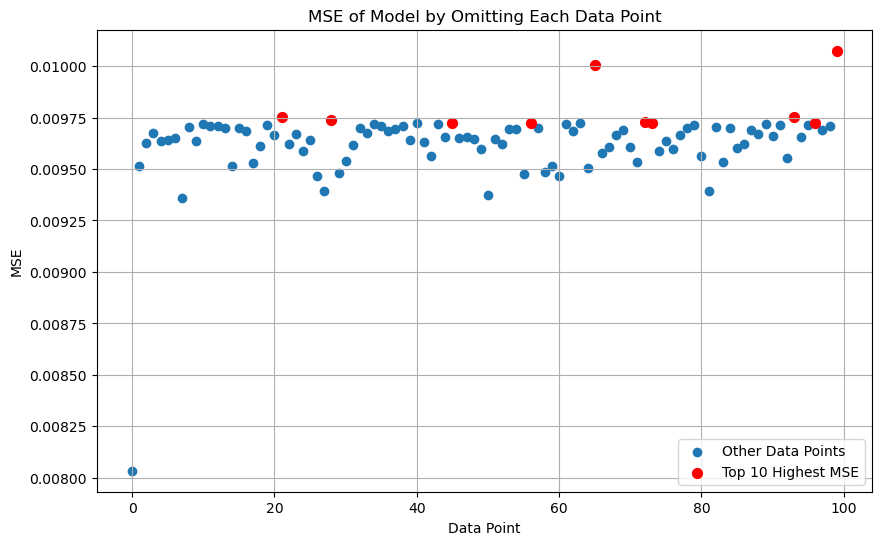

In [28]:
# Separating the top 10 highest MSE points
top_mse = importance_df.head(n_highlight)
other_mse = importance_df.iloc[n_highlight:]

# Plot 
plt.figure(figsize=(10, 6))
plt.scatter(importance_df['Data Point'], importance_df['MSE'], marker='o', linestyle='-', label='Other Data Points')

# Highlight the top 10 highest MSE values
plt.scatter(top_mse['Data Point'], top_mse['MSE'], color='red', s=50, label='Top 10 Highest MSE')

plt.xlabel('Data Point')
plt.ylabel('MSE')
plt.title('MSE of Model by Omitting Each Data Point')
plt.legend(loc="lower right")
plt.savefig('media/datapoint_removal_MSE_scatter.png')
plt.grid(True)
plt.show()

#### \<Extra question\>